In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.ttbar import TTDoubleLeptonGenDataset,TTDoubleLeptonRecoDataset
from memflow.read_data import utils
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [2]:
gen_data = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/TTTo2L2Nu.root',
    ],
    treenames = [
        'gen_TT;1',
    ],
    lazy = True,
    N = int(5e6),
)

print (gen_data)

Data object
Loaded branches:
   ... file: 5000000
   ... sample: 5000000
   ... tree: 5000000
Branch in files not loaded:
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12_phi
   ... ISR_12_pt
   ... ISR_13_E
   ... ISR_13_Px
   ... ISR_13_Py
   ... ISR_13_Pz
   ... ISR_13_eta
   ... ISR_13_idx
   ... ISR_13_mass
   ... ISR_13_parent
   ... ISR_13_pdgId
   ... ISR_13_phi
   ... ISR_13_pt
   ... ISR_14_E
   ... ISR_14_Px
   ... ISR_14_Py
   ... ISR_14_Pz
   ... ISR_14_eta
 

In [3]:
gen_dataset = TTDoubleLeptonGenDataset(
    data = gen_data,
    selection = [
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

Selecting 5000000 events out of 5000000
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/tt_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 5000000 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
leptons  : data ([5000000, 4, 4]), mask ([5000000, 4])
           Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
           Mask corr     : [True, True, True, True]
           Features      : ['pt', 'eta', 'phi', 'mass']
           Selected for batches : True
bquarks  : data ([5000000, 2, 4]), mask ([5000000, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Features      : ['pt', 'eta', 'phi', 'mass']
           Selected for batches : True
Preprocessing steps
Step applied to ['l

Before preprocessing


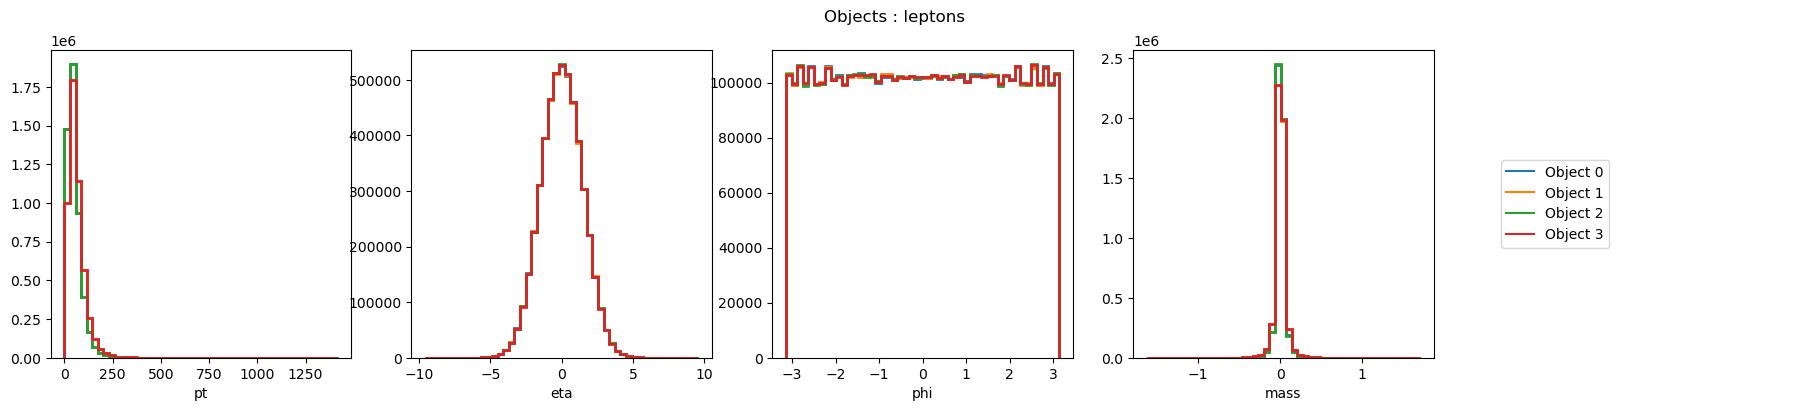

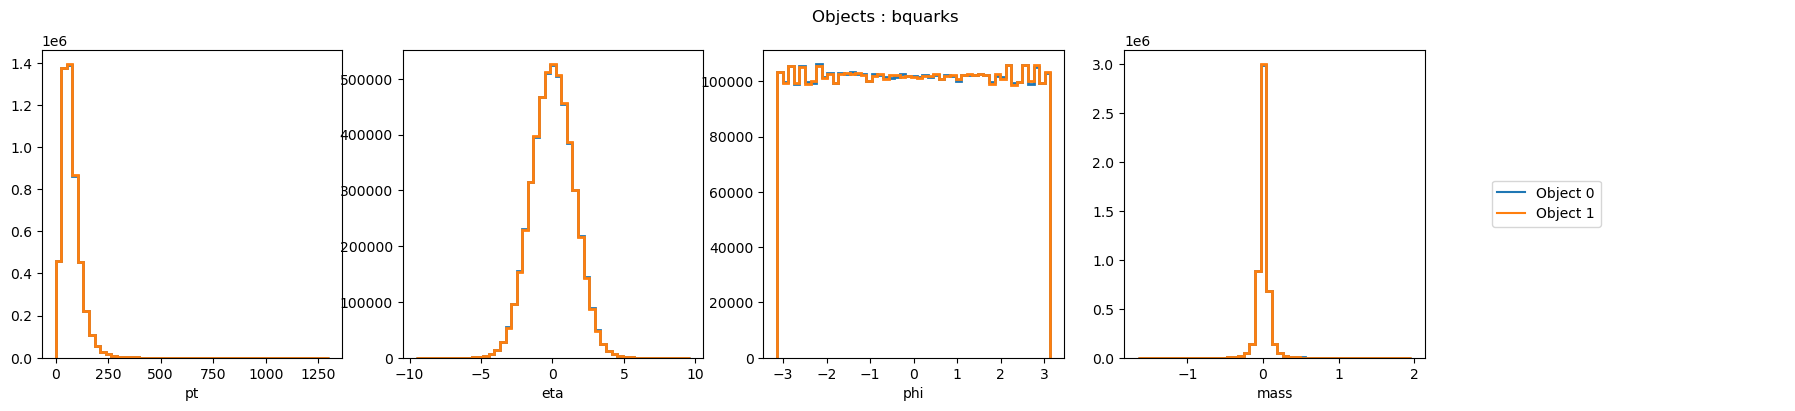

After preprocessing


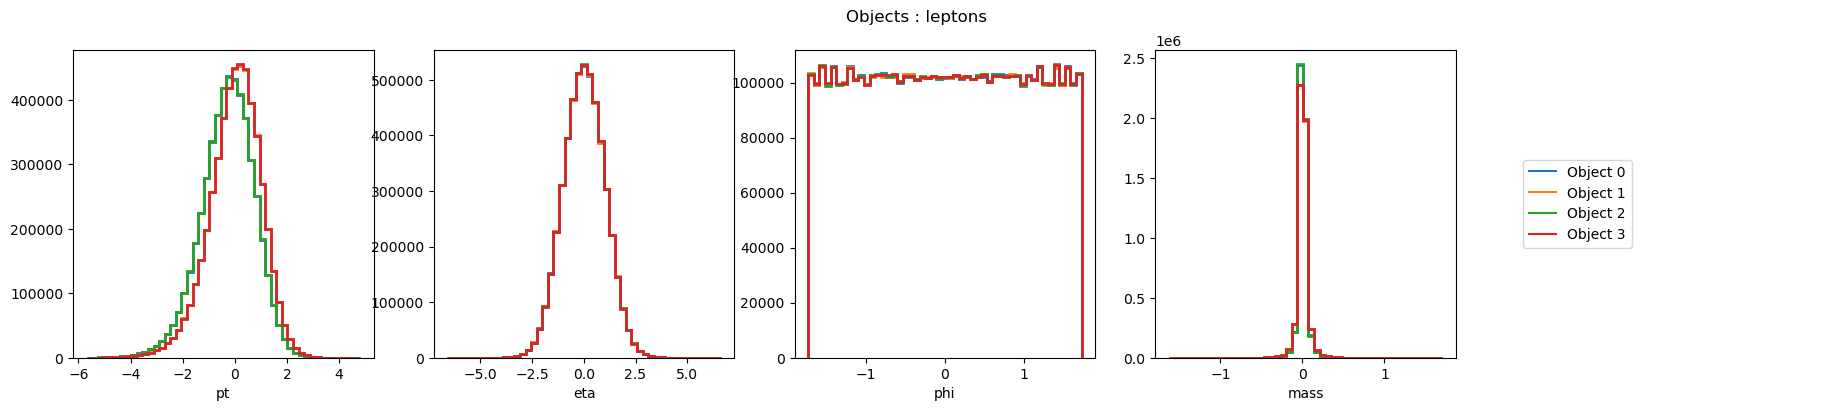

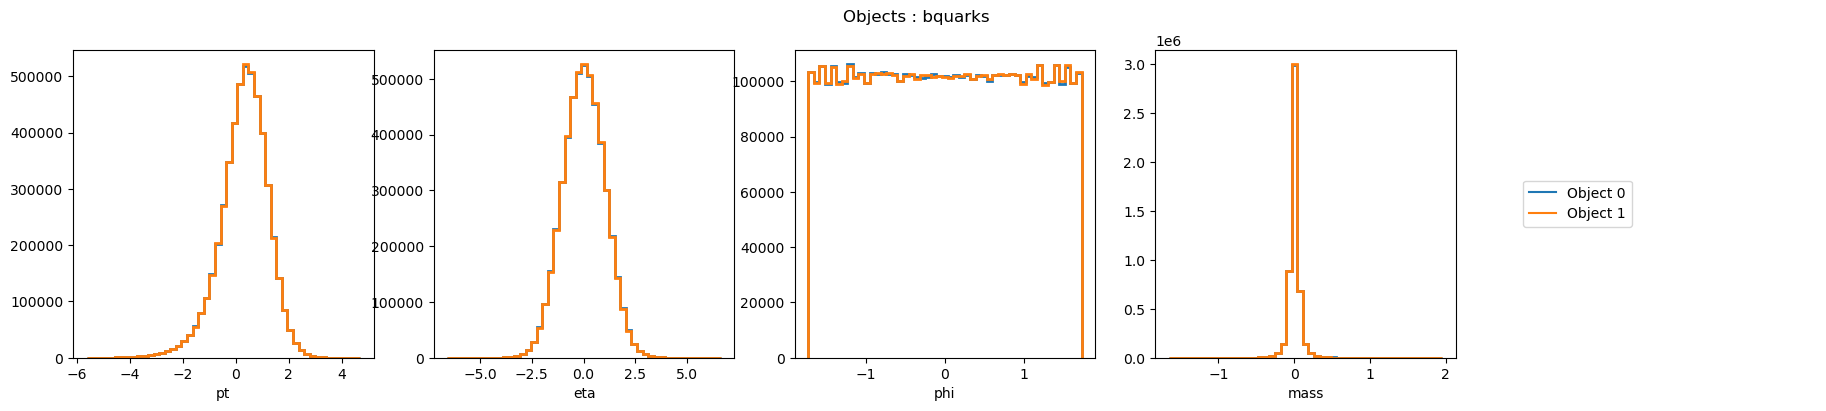

In [4]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [5]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

leptons torch.Size([32, 4, 4]) torch.Size([32, 4])
bquarks torch.Size([32, 2, 4]) torch.Size([32, 2])


In [6]:
reco_data = RootData(
    files = gen_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = gen_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)


Initial : 5000000
Resolved SR : 895879
Data object
Loaded branches:
   ... file: 895879
   ... flag_SR: 895879
   ... flag_resolved: 895879
   ... n_AK4: 895879
   ... sample: 895879
   ... tree: 895879
Branch in files not loaded:
   ... VBF1_E
   ... VBF1_Px
   ... VBF1_Py
   ... VBF1_Pz
   ... VBF1_eta
   ... VBF1_idx
   ... VBF1_mass
   ... VBF1_phi
   ... VBF1_pt
   ... VBF1_sel
   ... VBF2_E
   ... VBF2_Px
   ... VBF2_Py
   ... VBF2_Pz
   ... VBF2_eta
   ... VBF2_idx
   ... VBF2_mass
   ... VBF2_phi
   ... VBF2_pt
   ... VBF2_sel
   ... VBF3_E
   ... VBF3_Px
   ... VBF3_Py
   ... VBF3_Pz
   ... VBF3_eta
   ... VBF3_idx
   ... VBF3_mass
   ... VBF3_phi
   ... VBF3_pt
   ... VBF3_sel
   ... VBF4_E
   ... VBF4_Px
   ... VBF4_Py
   ... VBF4_Pz
   ... VBF4_eta
   ... VBF4_idx
   ... VBF4_mass
   ... VBF4_phi
   ... VBF4_pt
   ... VBF4_sel
   ... VBF5_E
   ... VBF5_Px
   ... VBF5_Py
   ... VBF5_Pz
   ... VBF5_eta
   ... VBF5_idx
   ... VBF5_mass
   ... VBF5_phi
   ... VBF5_pt
   ... VBF

In [7]:
reco_dataset = TTDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/tt_reco
Reco dataset with 895879 events
Containing the following tensors
boost      : data ([895879, 1, 7]), mask ([895879, 1])
             Mask exist    : [100.00%]
             Mask corr     : [True]
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : False
jets       : data ([895879, 8, 7]), mask ([895879, 8])
             Mask exist    : [100.00%, 99.98%, 52.57%, 21.23%, 7.15%, 2.11%, 0.56%, 0.11%]
             Mask corr     : [True, True, False, False, False, False, False, False]
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : True
electrons  : data ([895879, 2, 7]), mask ([895879, 2])
             Mask exist    : [67.88%, 18.90%]
             Mask corr     : [True, True]
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Sel

In [8]:
event = 5
print ('jets')
print (reco_dataset._objects['jets'][0][event])
print (reco_dataset._objects['jets'][1][event])
print ('electrons')
print (reco_dataset._objects['electrons'][0][event])
print (reco_dataset._objects['electrons'][1][event])
print ('muons')
print (reco_dataset._objects['muons'][0][event])
print (reco_dataset._objects['muons'][1][event])
print ('met')
print (reco_dataset._objects['met'][0][event])
print (reco_dataset._objects['met'][1][event])

jets
tensor([[-3.3017e-01, -1.7171e+00,  1.5982e+00,  9.5410e-01,  0.0000e+00,
          0.0000e+00,  6.8228e+00],
        [-4.0579e-02,  1.9453e+00,  4.0086e-01,  4.5801e-01,  0.0000e+00,
          0.0000e+00,  8.8673e+00],
        [-1.1482e+00, -2.9298e-01,  7.0834e-01,  1.0605e-02,  0.0000e+00,
          0.0000e+00,  6.7770e+00],
        [-8.8278e-01,  7.4295e-01,  4.1647e-01,  7.9193e-03,  0.0000e+00,
          0.0000e+00,  9.3541e+00],
        [ 1.0684e+00,  8.5922e-01, -8.2769e-01,  2.4509e-03,  0.0000e+00,
          0.0000e+00,  1.1153e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor([1., 1., 1., 1., 1., 0., 0., 0.])
electrons
tensor([[ 0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,

Before preprocessing


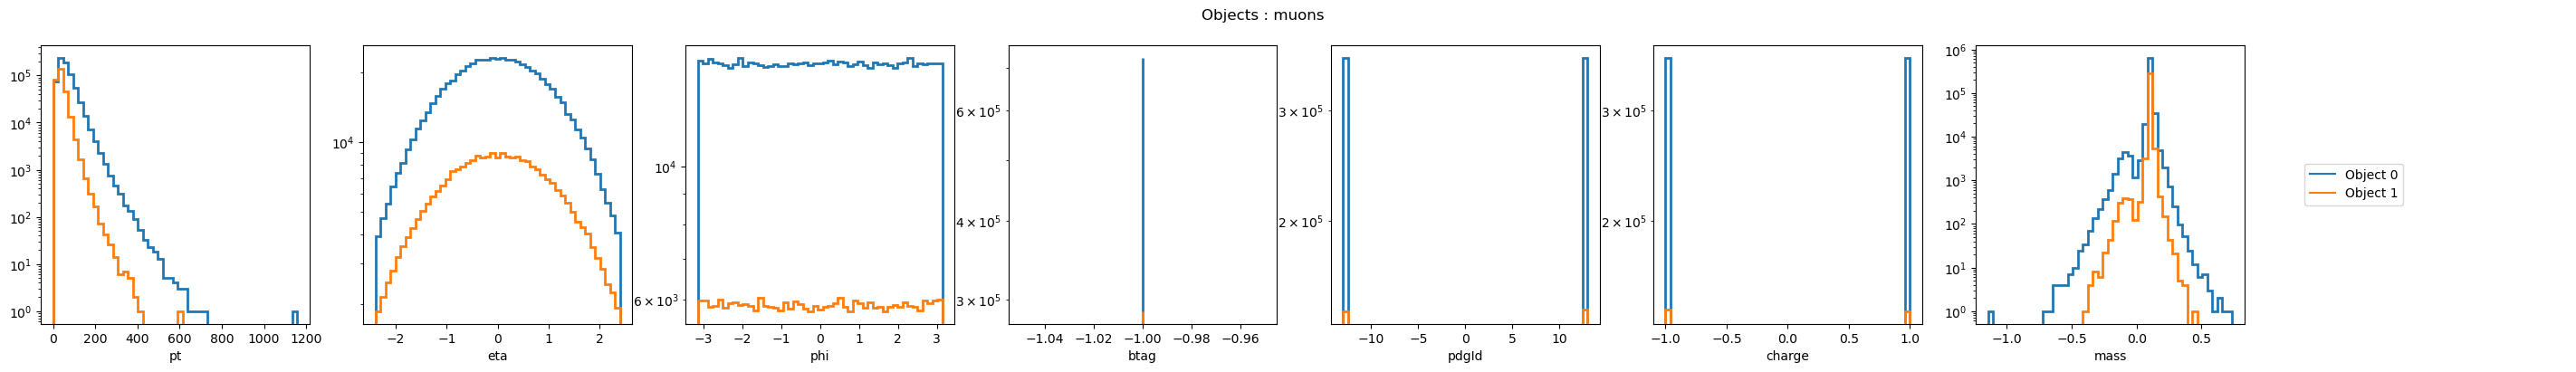

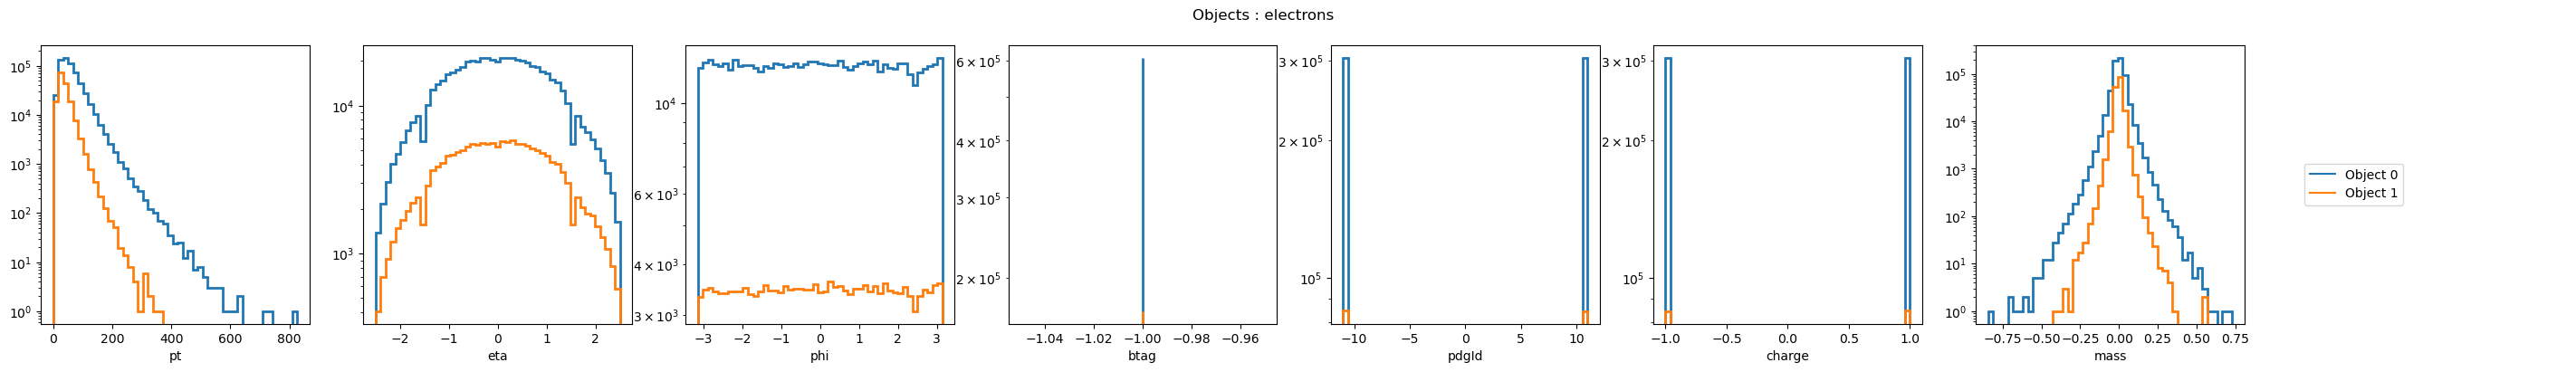

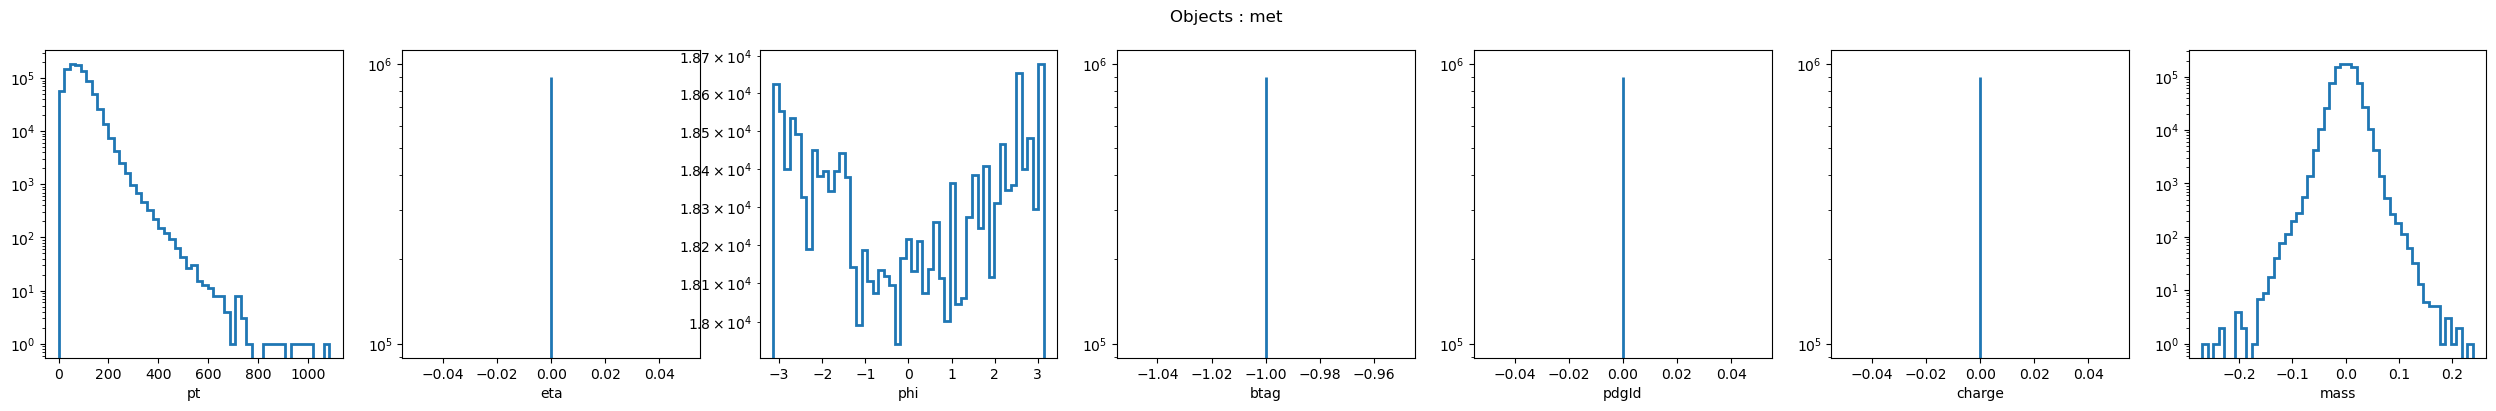

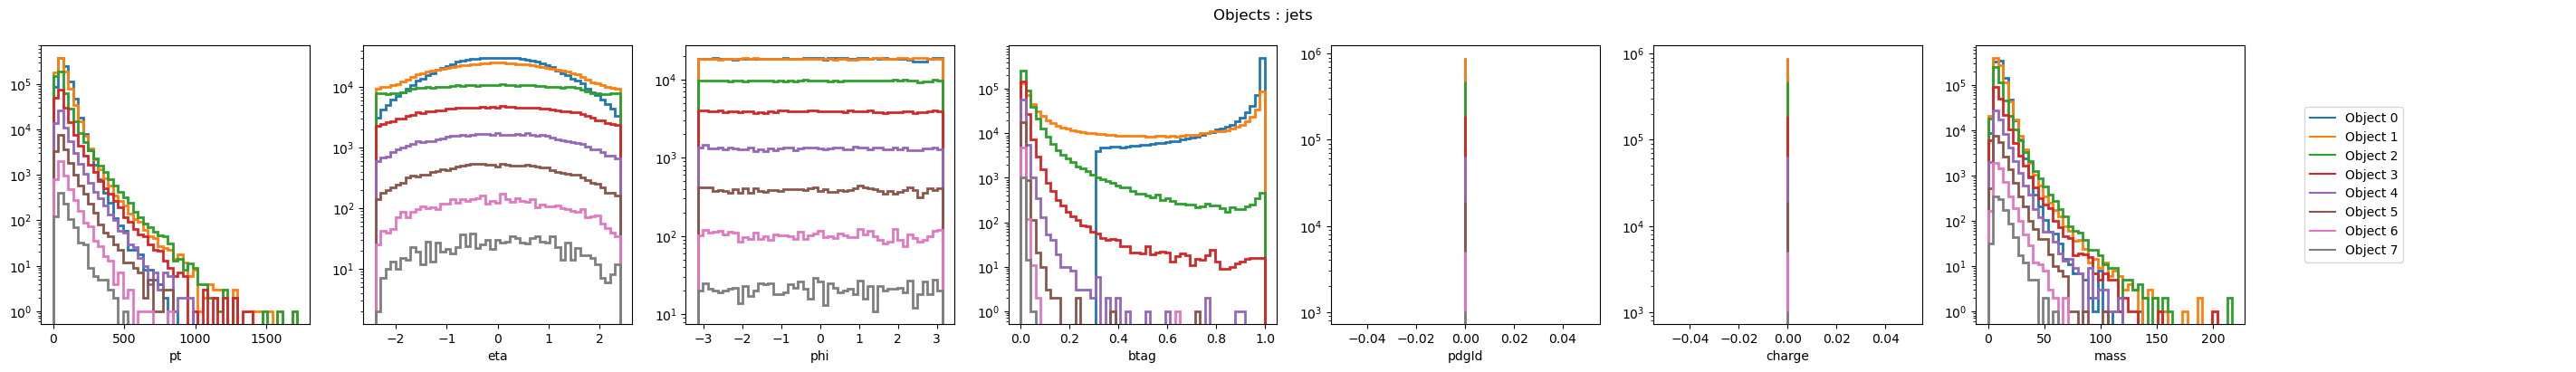

After preprocessing


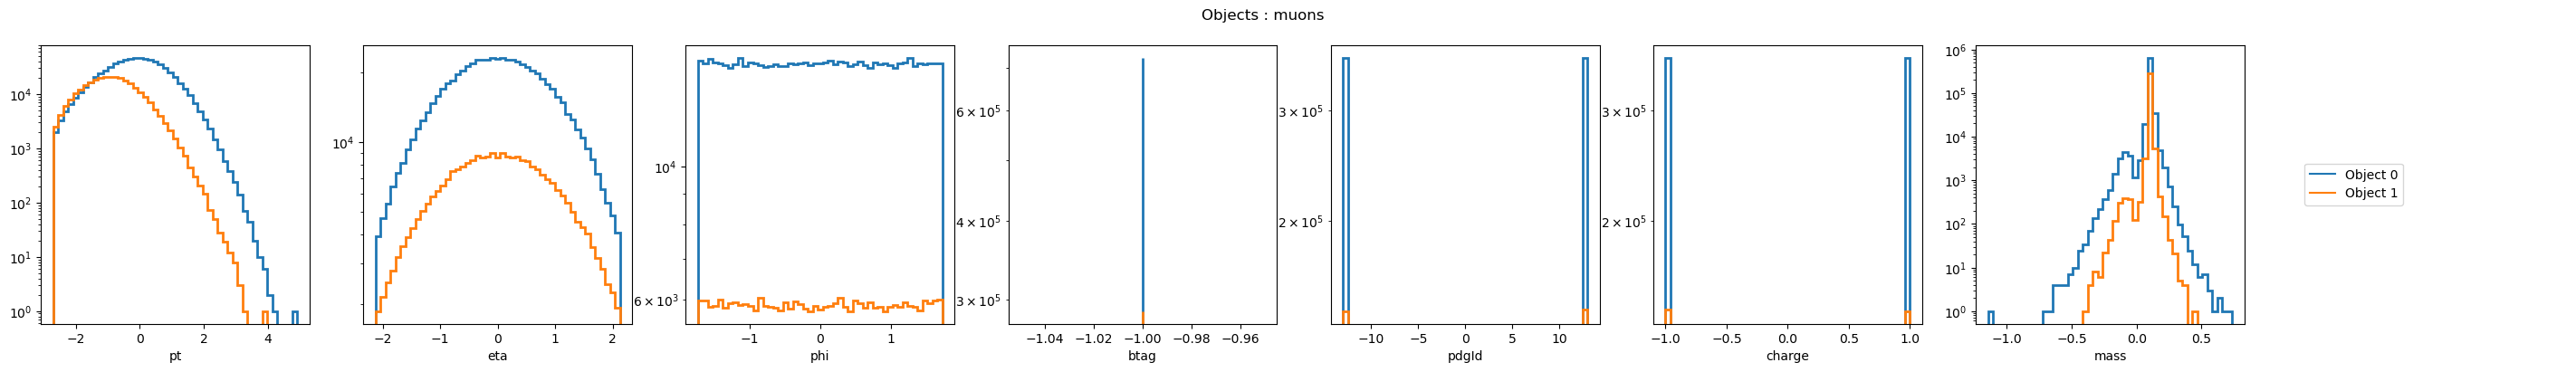

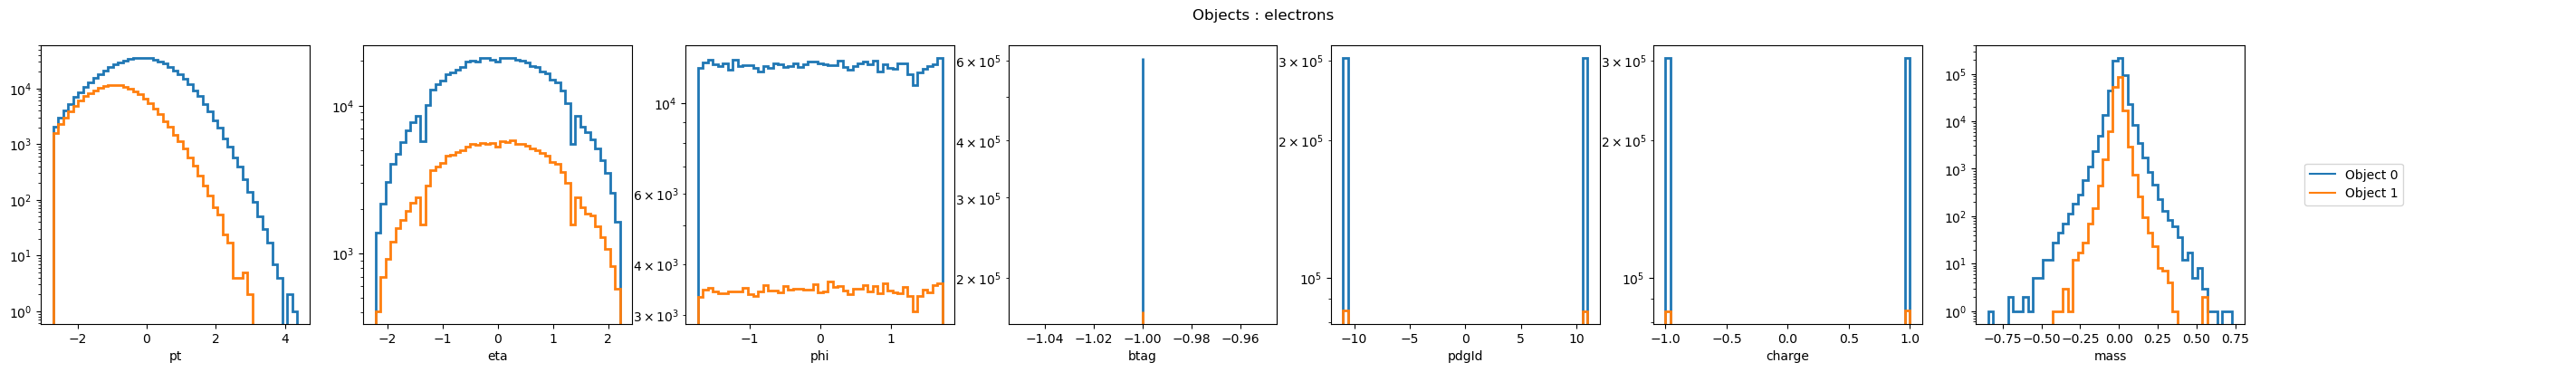

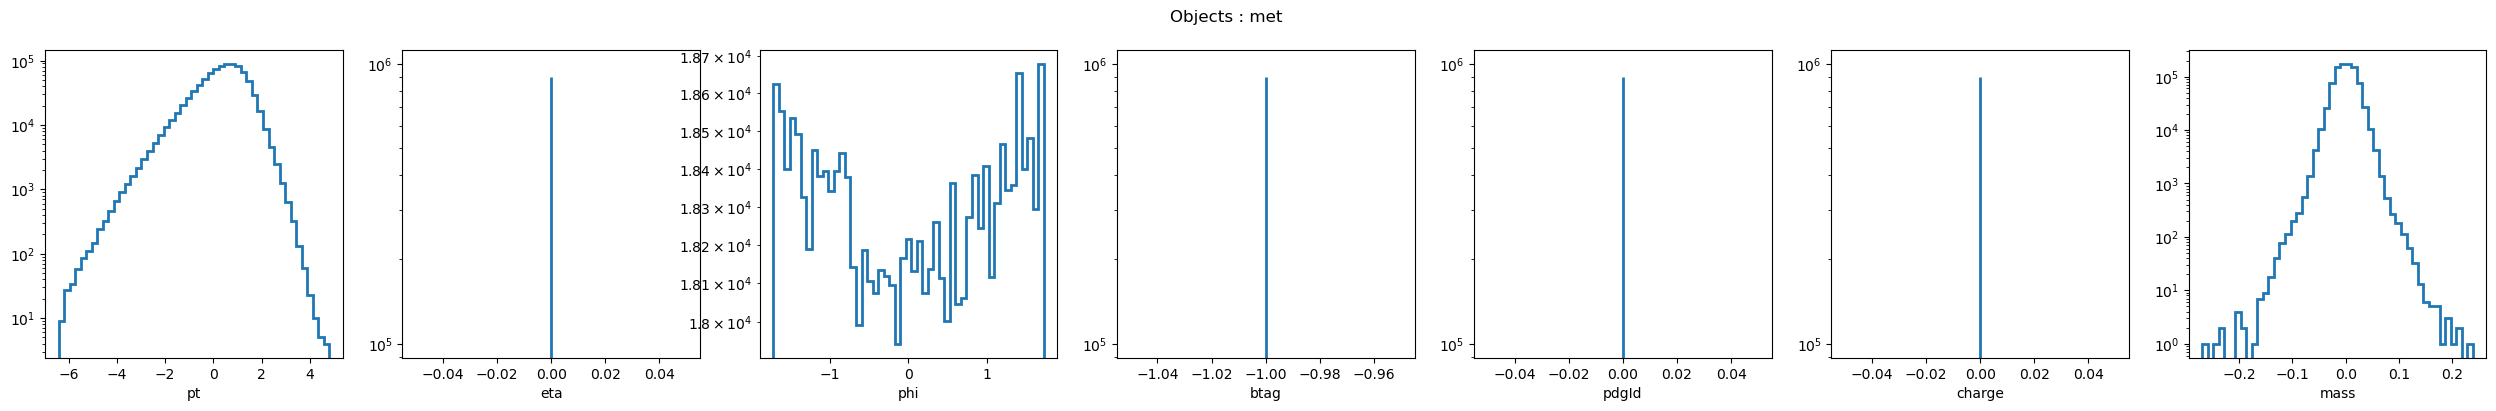

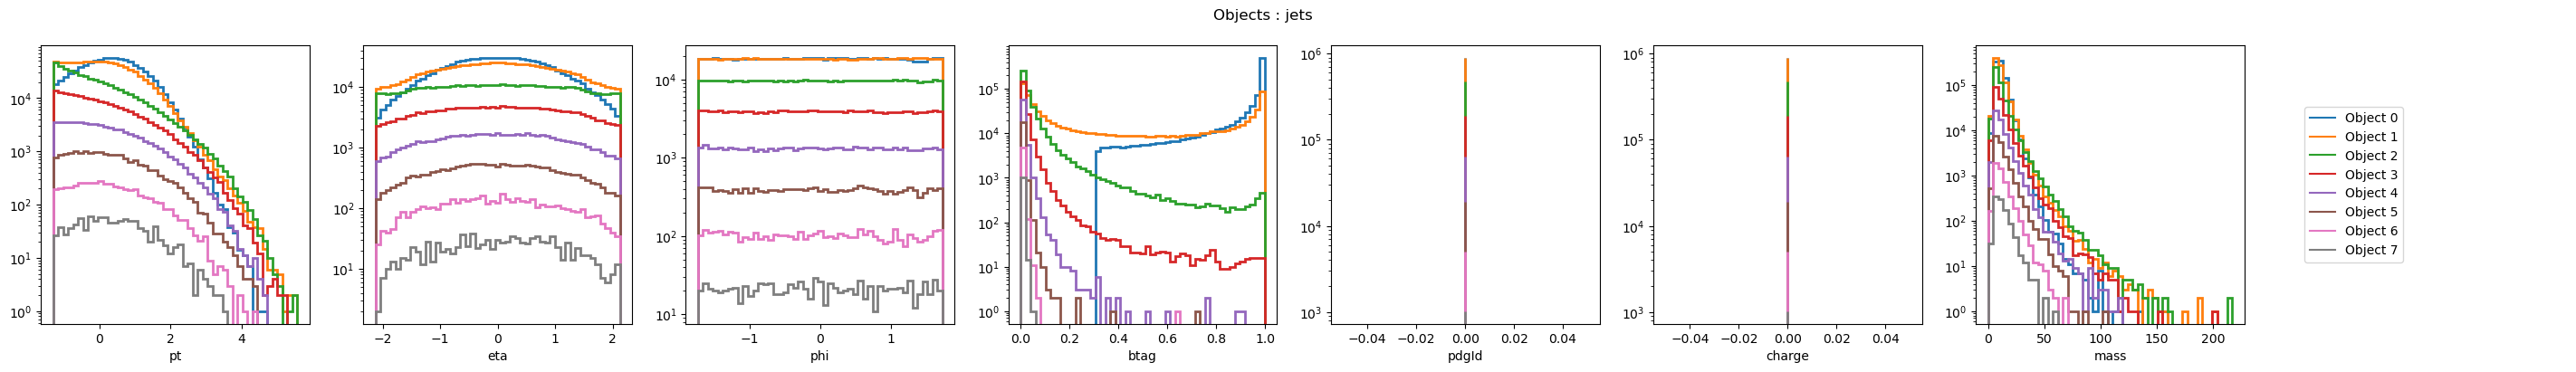

In [9]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [10]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

muons torch.Size([32, 2, 7]) torch.Size([32, 2])
electrons torch.Size([32, 2, 7]) torch.Size([32, 2])
met torch.Size([32, 1, 7]) torch.Size([32, 1])
jets torch.Size([32, 8, 7]) torch.Size([32, 8])


In [11]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

Looking into file metadata
	entry 0 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/TTTo2L2Nu.root']
	entry 1 : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/TTTo2L2Nu.root']
Will only consider common files : ['/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/TTTo2L2Nu.root']
(Note : this assumes the files have the same order between the different data objects
For entry 0 : from 5000000 events, 895879 selected
For entry 1 : from 895879 events, 895879 selected
Combined dataset (extracting 895879 events of the following) :
Parton dataset with 5000000 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -12, -11, 12]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0, 0.0005109989499999999, 0.0]
Containing the following tensors
leptons  : data ([5000000, 4, 4]), mask ([5000000, 4])
           Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
           Mask corr     : [True, True, True, True]
           Features   

In [12]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
muons torch.Size([256, 2, 7]) torch.Size([256, 2])
electrons torch.Size([256, 2, 7]) torch.Size([256, 2])
met torch.Size([256, 1, 7]) torch.Size([256, 1])
jets torch.Size([256, 8, 7]) torch.Size([256, 8])
Gen
leptons torch.Size([256, 4, 4]) torch.Size([256, 4])
bquarks torch.Size([256, 2, 4]) torch.Size([256, 2])


In [13]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 5000

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

716703 179176


In [14]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    gen_particle_type_names = gen_dataset.selection,
    gen_input_features_per_type = gen_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : 2,
        # 'univariate'
        # 'univariate_kwargs' : {"bound": 1},
        'hidden_features' : [64] * 5,   
    },
    onehot_encoding = True,
)

batch = next(iter(loader_comb))
print (model(batch))

print (model)

(tensor([[6.3442, 0.0000, 5.8105,  ..., 0.0000, 0.0000, 0.0000],
        [3.4754, 3.7248, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.1495, 0.0000, 6.8066,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.1780, 4.5227, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.8033, 0.0000, 4.7347,  ..., 0.0000, 0.0000, 0.0000],
        [5.6316, 5.6471, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<NegBackward0>), tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]]))
TransferFlow(
  (gen_embeddings): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (reco_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=21, out_features=64, bias=True)
      (1): G

In [15]:
idx_ee = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 2,
    ]
)
idx_mm = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['muons'],axis=1) == 2,
    ]
)
idx_em = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 1,
        ak.count(reco_data['muons'],axis=1) == 1,
    ]
)
for channel,idx in zip(['ee','mm','em'],[idx_ee,idx_mm,idx_em]):
    print (channel)
    for i in idx[:3]:
        event = comb_dataset[i]
        print ('\t idx:',i)
        print ('\t reco: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['reco']['data'],event['reco']['mask']):
            print (f'\t\t{name:15s}',data.shape,mask)
        print ('\t gen: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['gen']['data'],event['gen']['mask']):
            print (f'\t\t{name:15s}')
            print (f'\t\t',data)
            print (f'\t\t',mask)


ee
	 idx: 3664
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 1., 1., 1., 1., 1., 1., 1.])
	 gen: 
		muons          
		 tensor([[-1.5504e+00, -6.1985e-02, -1.3956e+00,  2.0792e-03],
        [-2.1069e+00,  2.3551e+00,  2.2450e-01,  4.9479e-02],
        [ 6.1377e-01,  1.4247e-01, -9.0241e-01,  9.6121e-03],
        [-4.8324e-01,  5.4834e-01, -8.9937e-02,  1.0557e-02]])
		 tensor([1., 1., 1., 1.])
		electrons      
		 tensor([[ 1.0421,  0.5726,  0.9304,  0.0471],
        [-0.3514,  1.4820, -1.0381,  0.0427]])
		 tensor([1., 1.])
	 idx: 9879
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 1., 1., 1., 1., 1., 1., 1.])
	 gen: 
		muons          
		 tensor([[ 0.03

In [16]:
idx_to_monitor = [idx_ee[0],idx_mm[0],idx_em[0]]
print ('Reco')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['reco']['data'],comb_dataset[idx]['reco']['mask'],comb_dataset.reco_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)
print ('Gen')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['gen']['data'],comb_dataset[idx]['gen']['mask'],comb_dataset.gen_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)


Reco
idx 3664
	 muons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 1280
	 muons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 electrons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 301
	 muons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Gen
idx 3664
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 4])
	 tensor([1., 1.])
idx 1280
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 4])
	 tensor([1., 1.])
idx 301
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2,

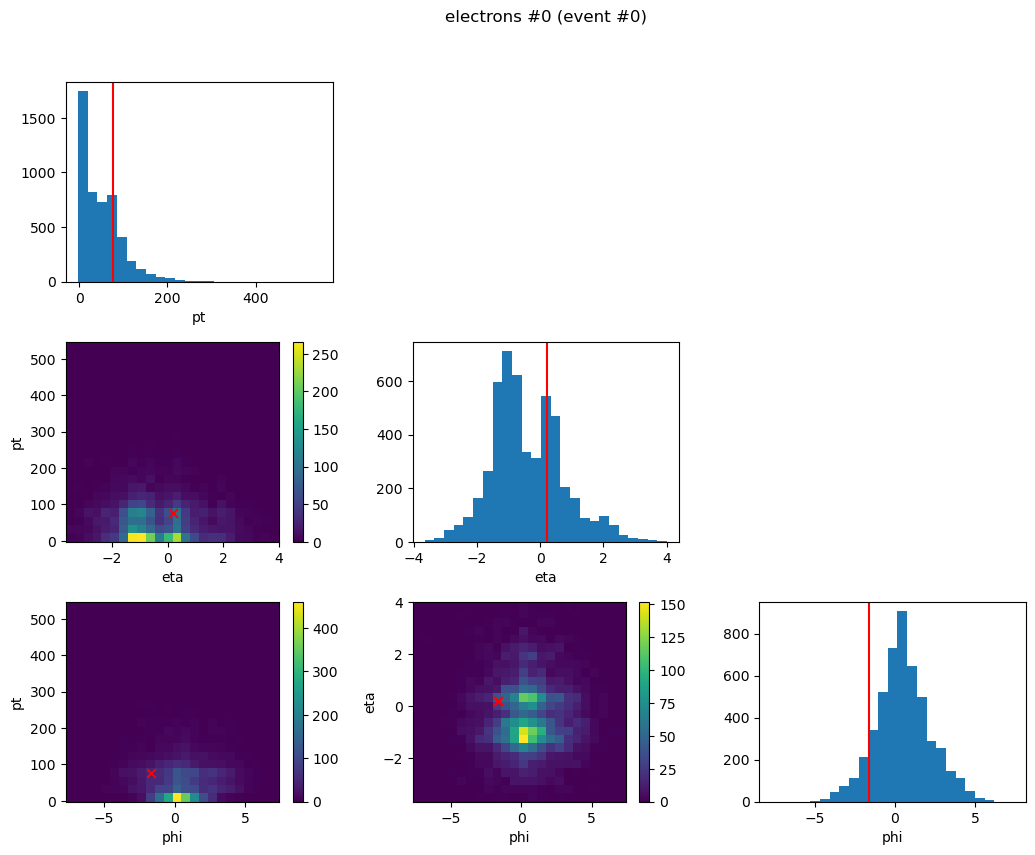

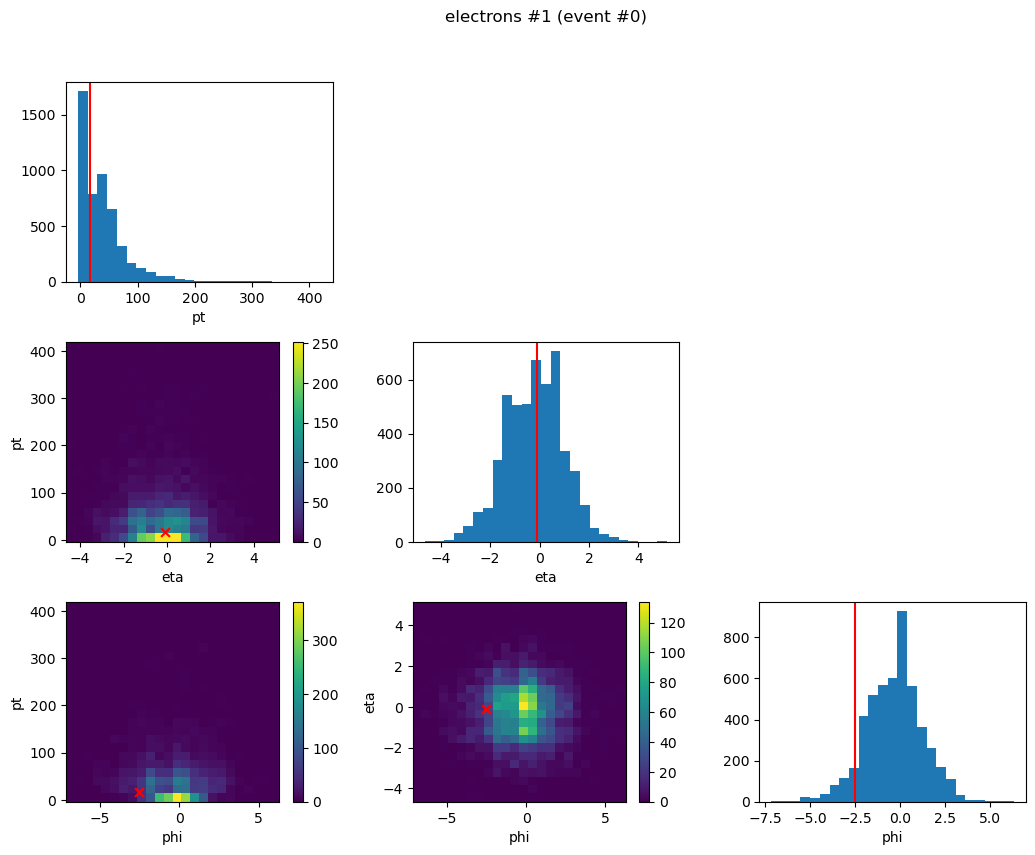

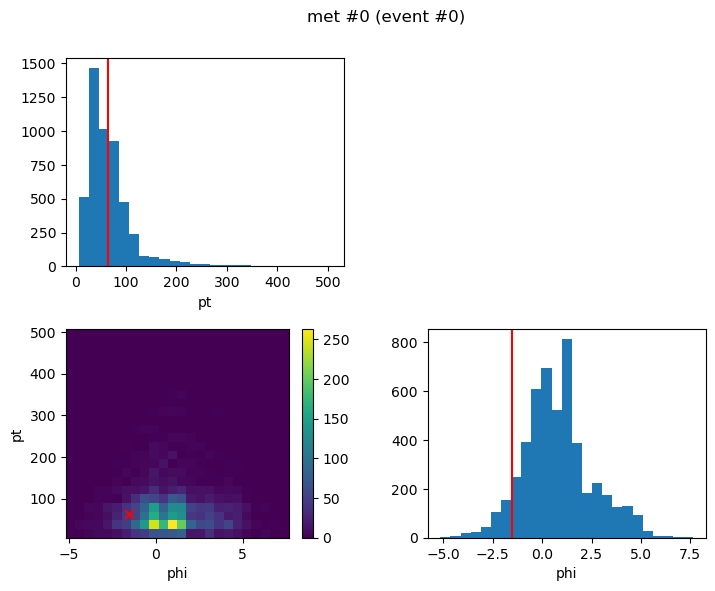

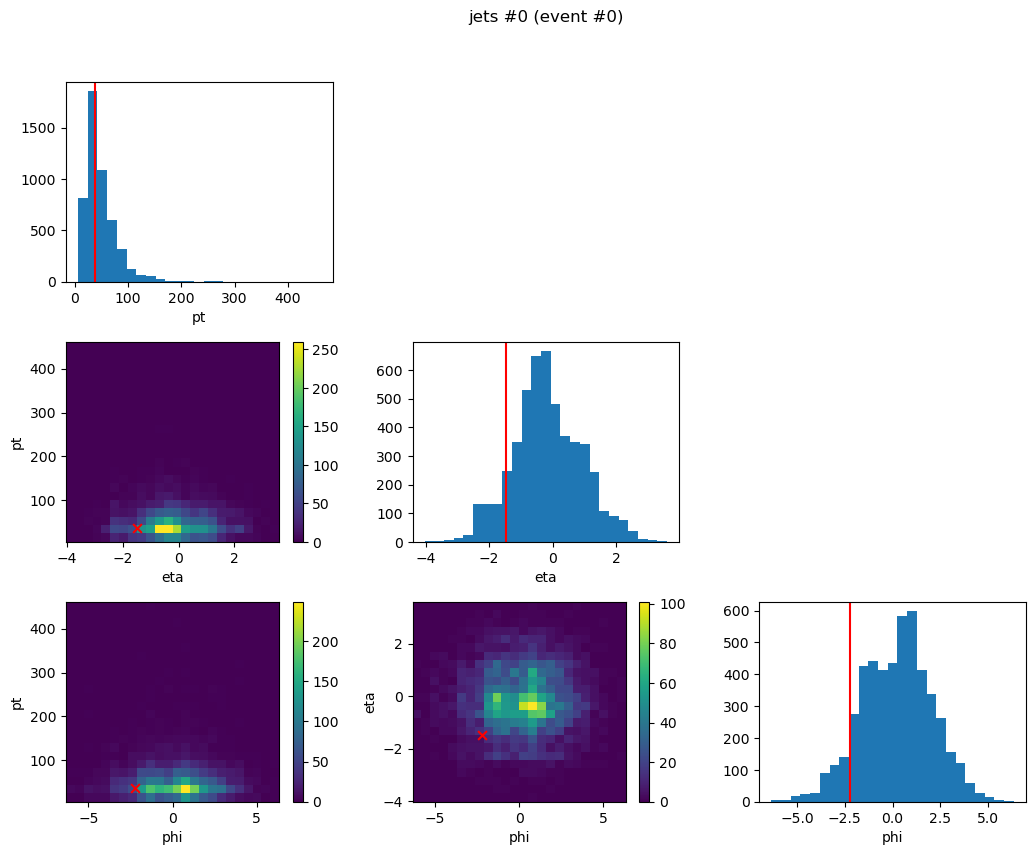

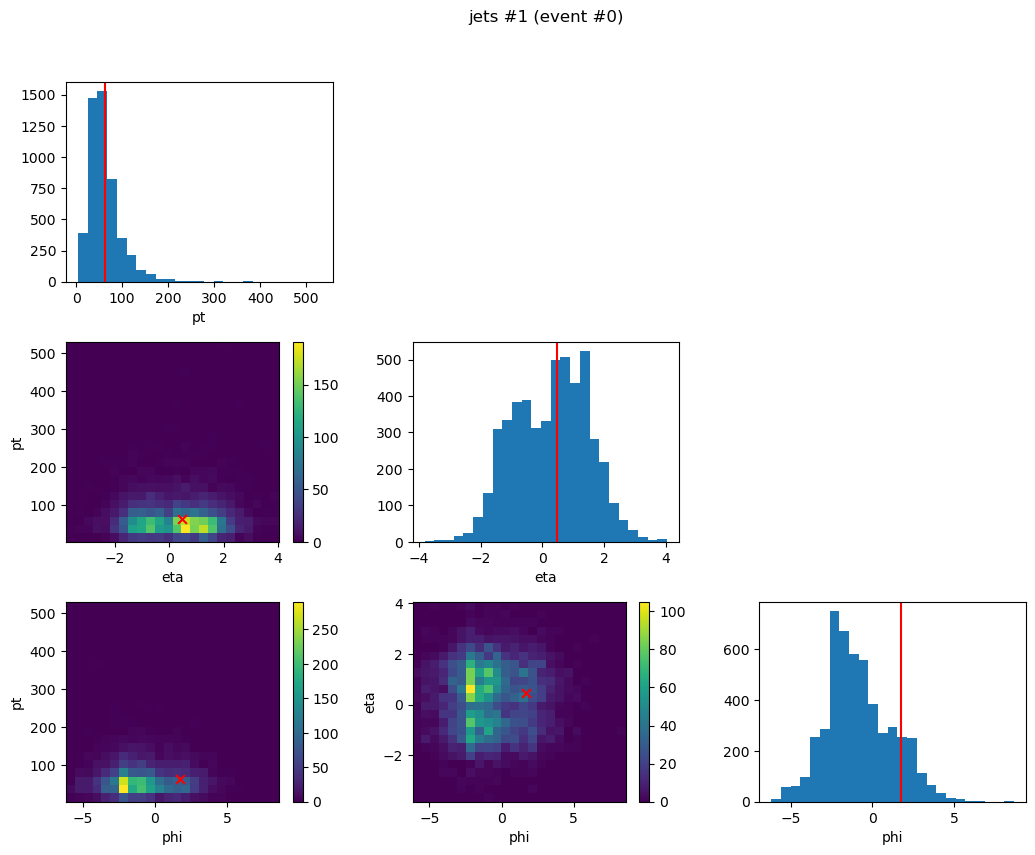

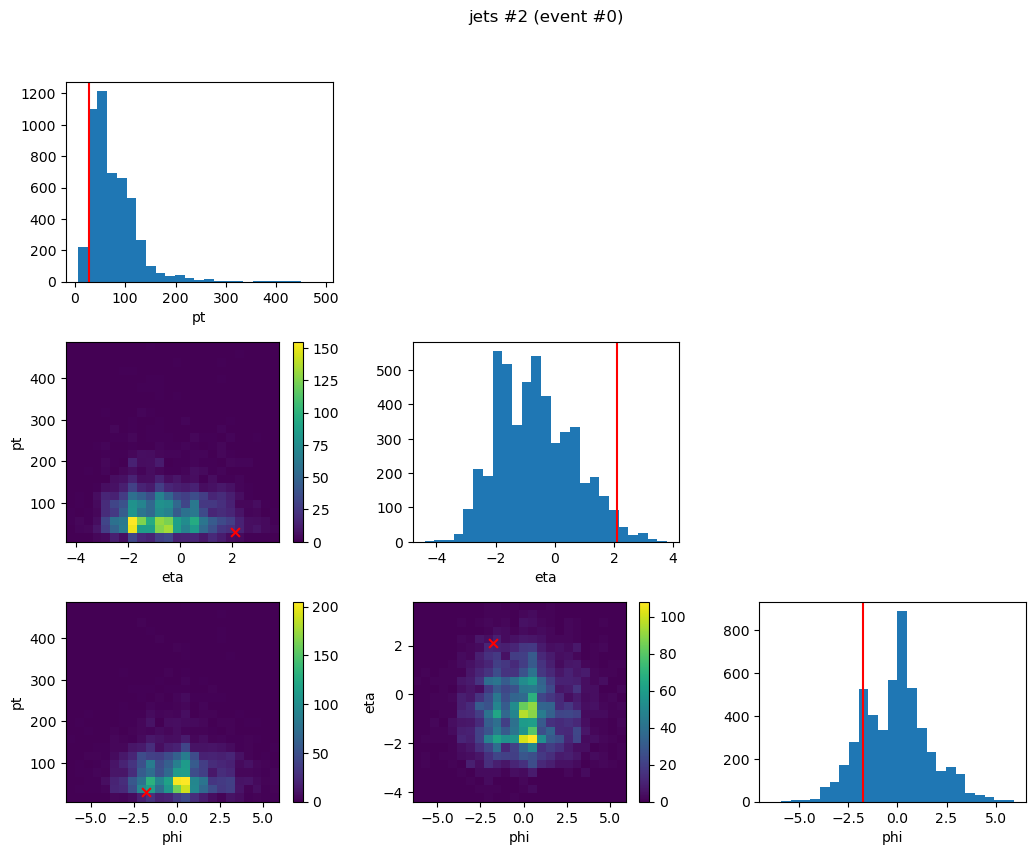

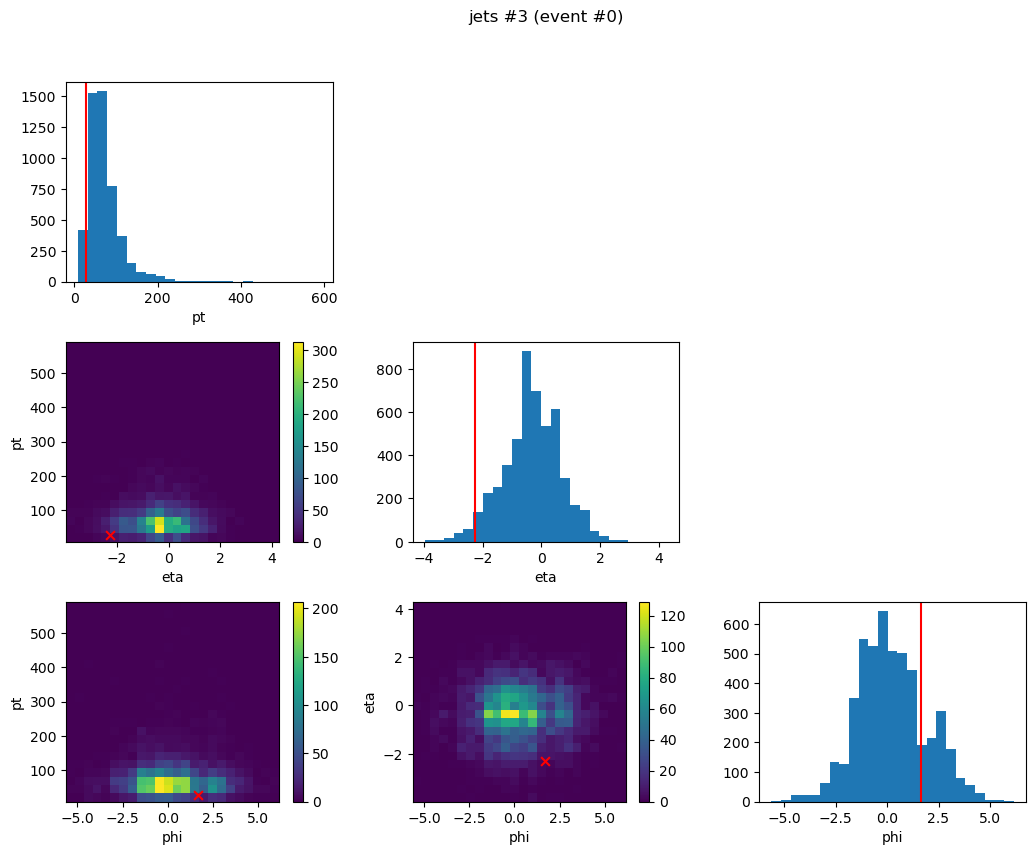

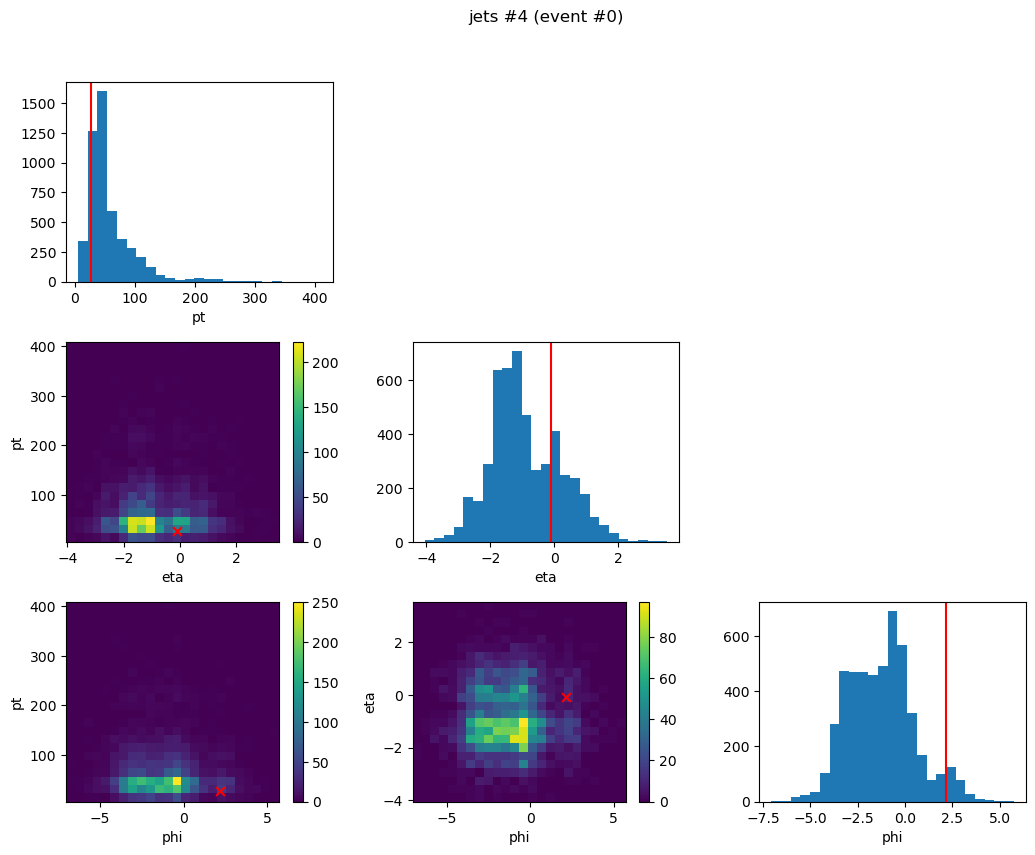

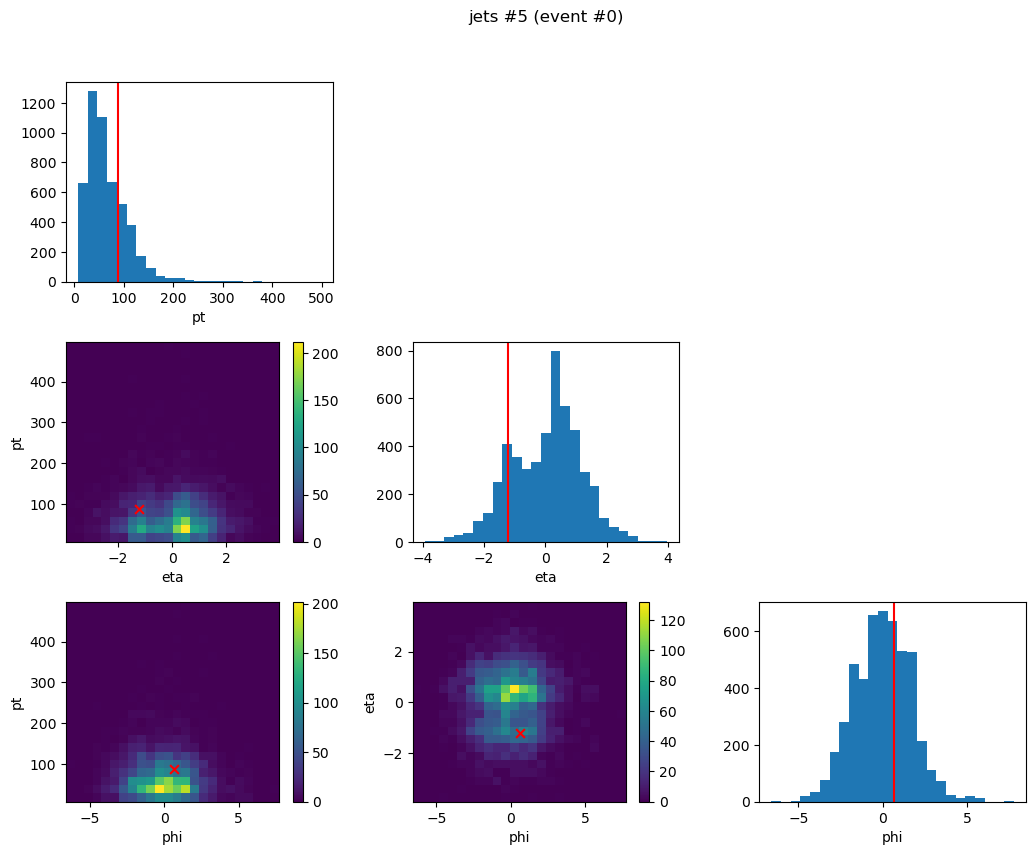

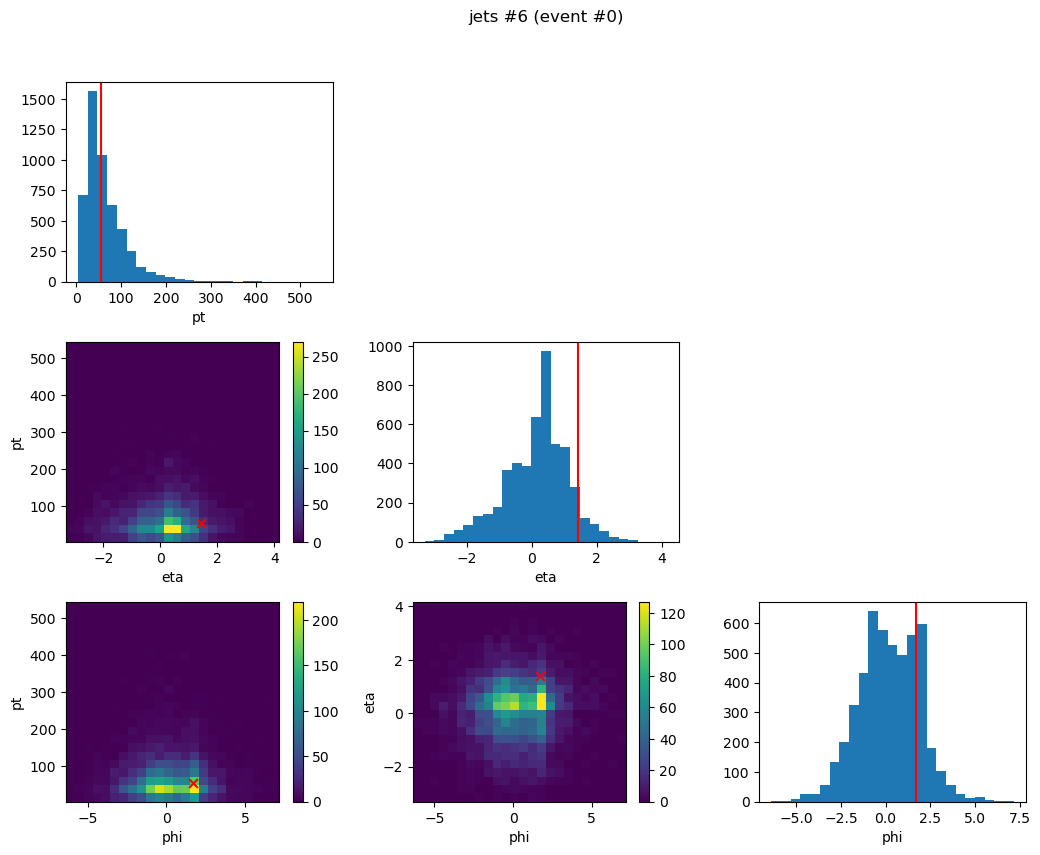

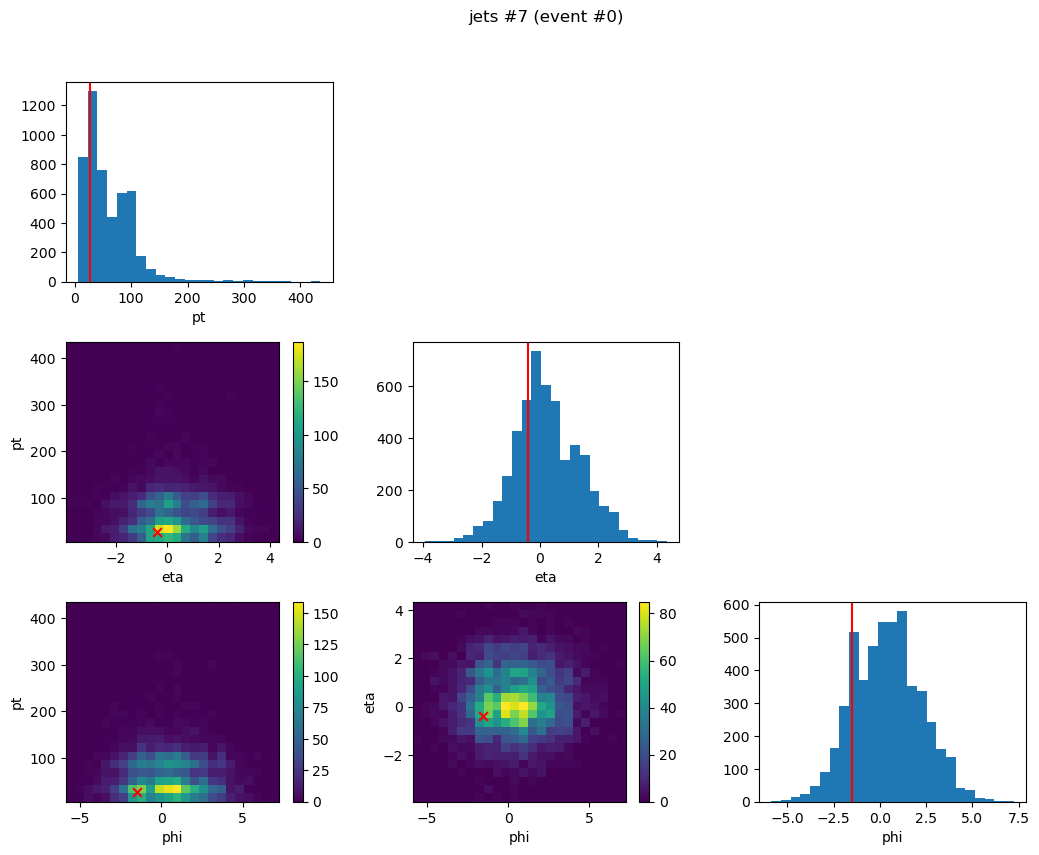

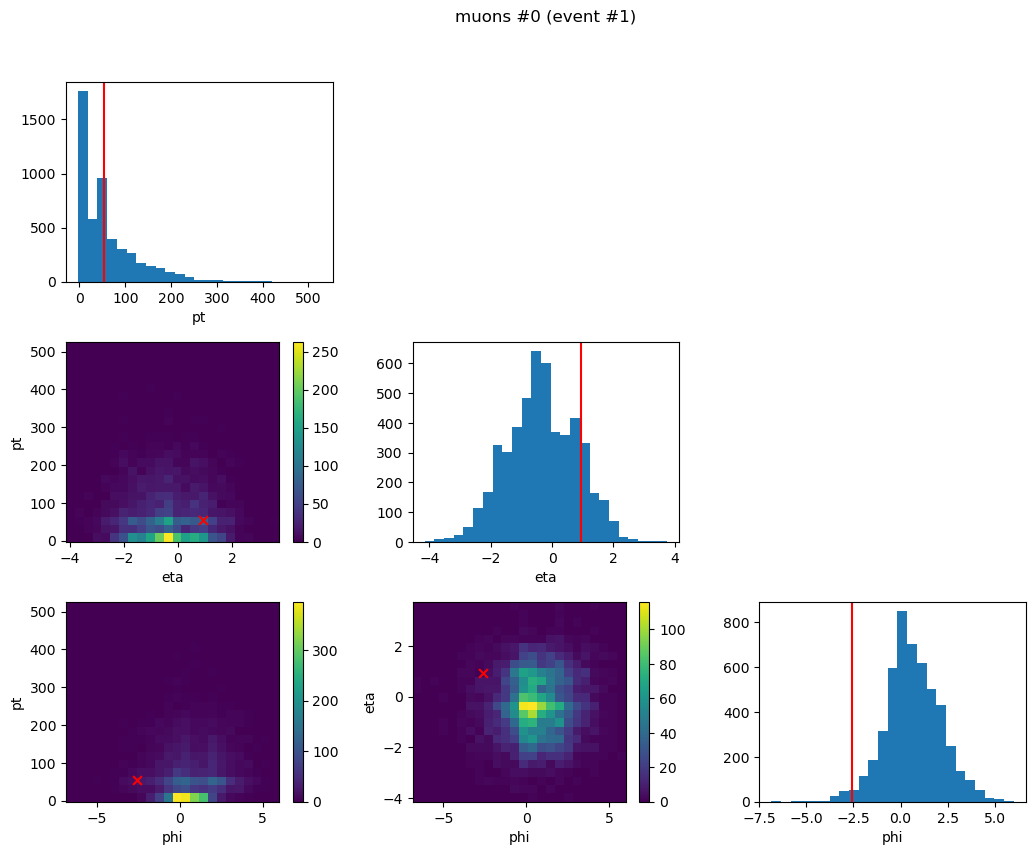

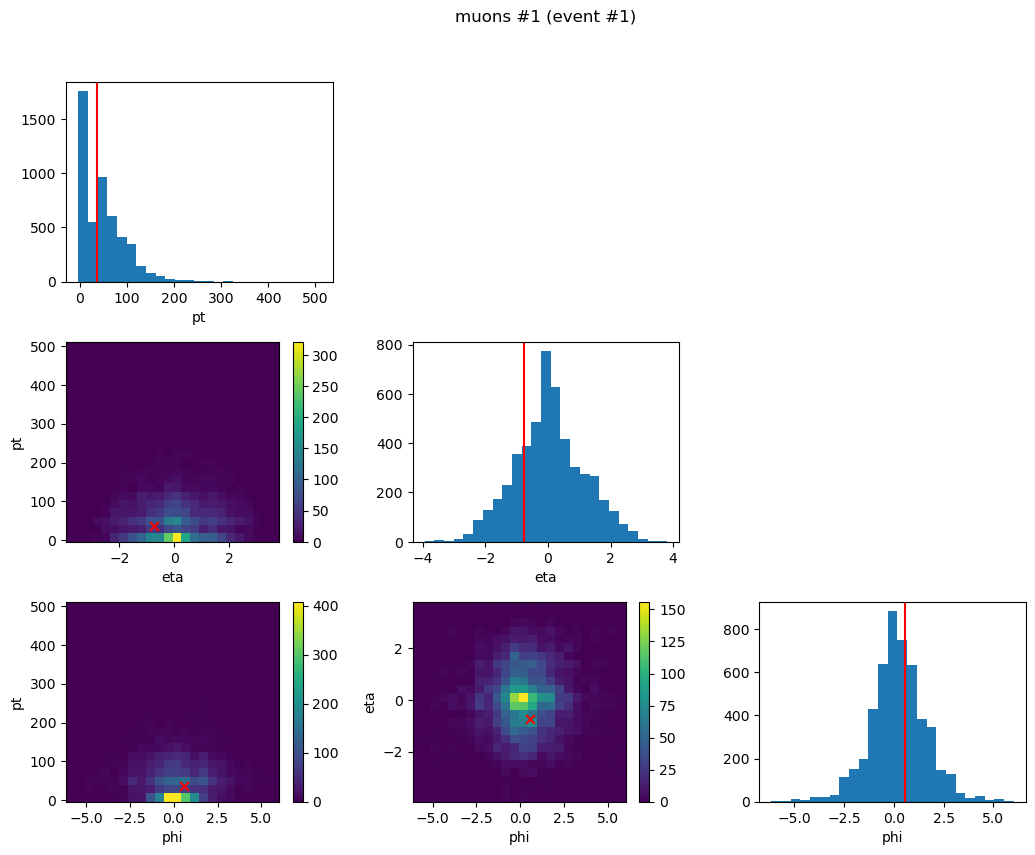

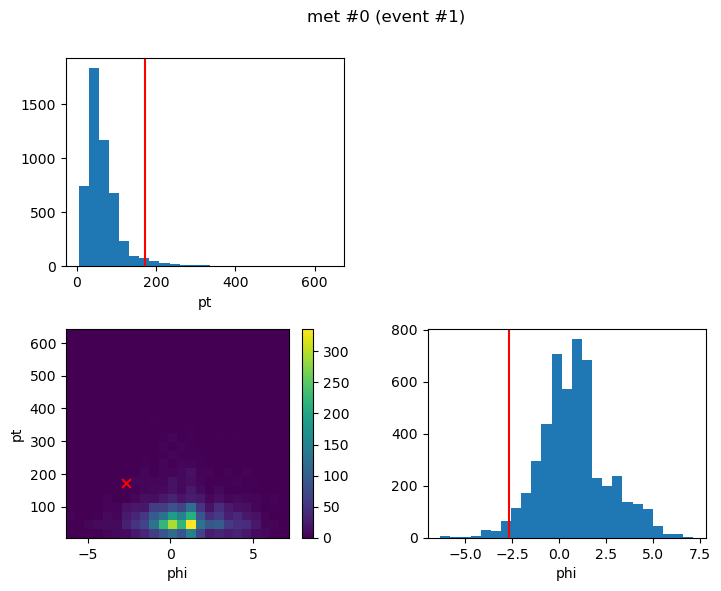

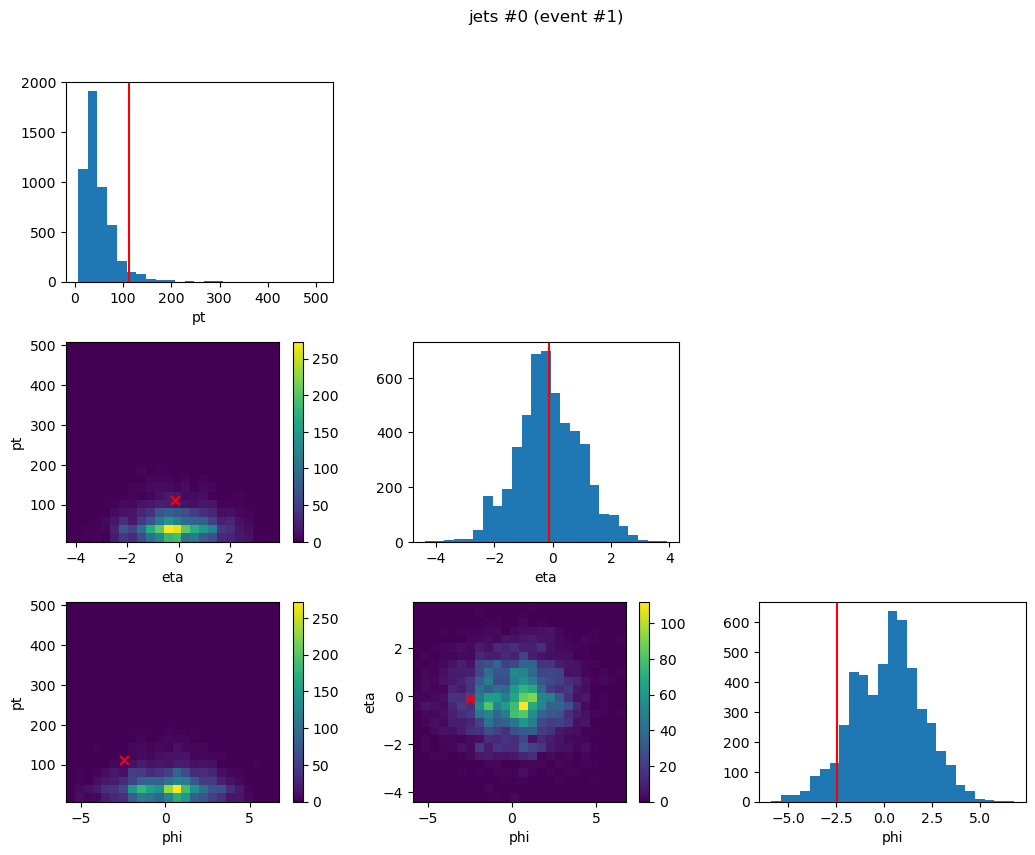

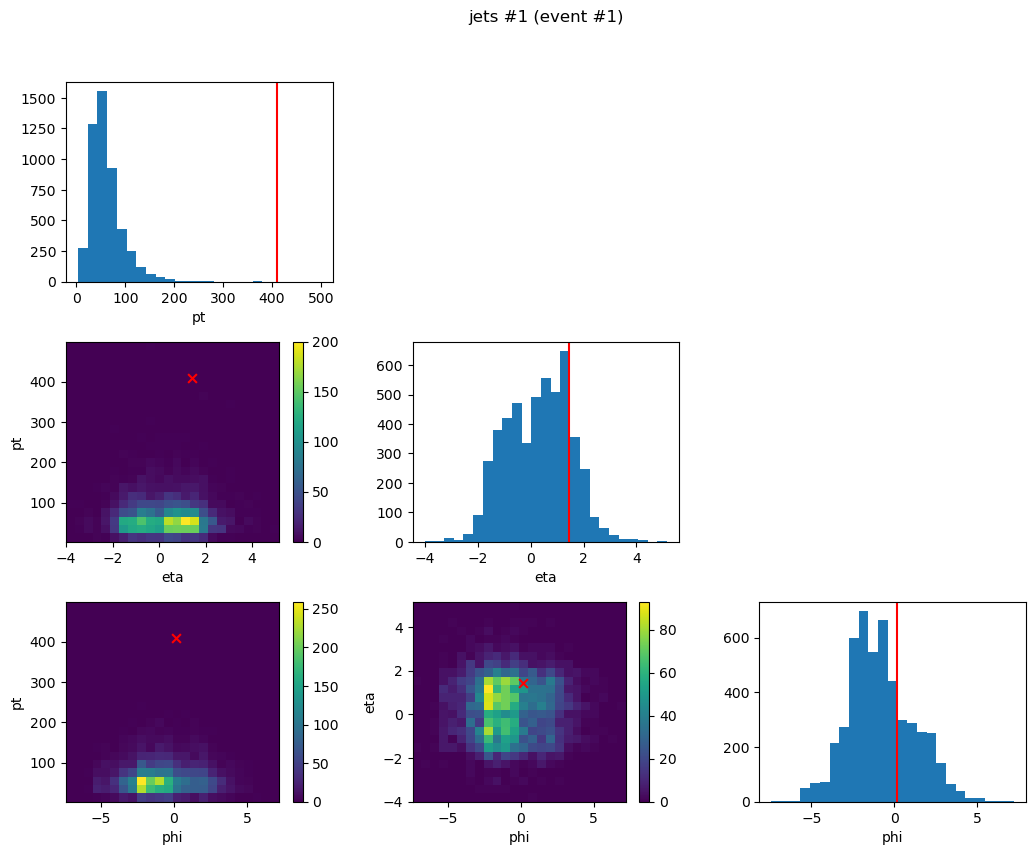

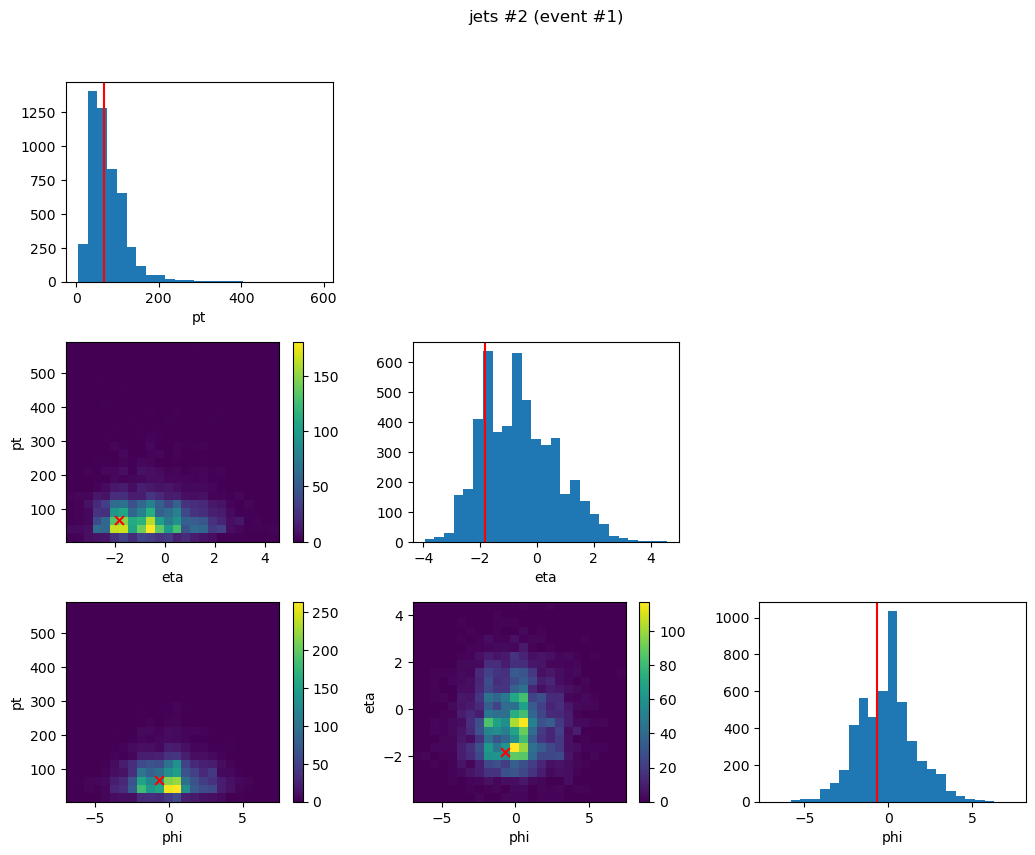

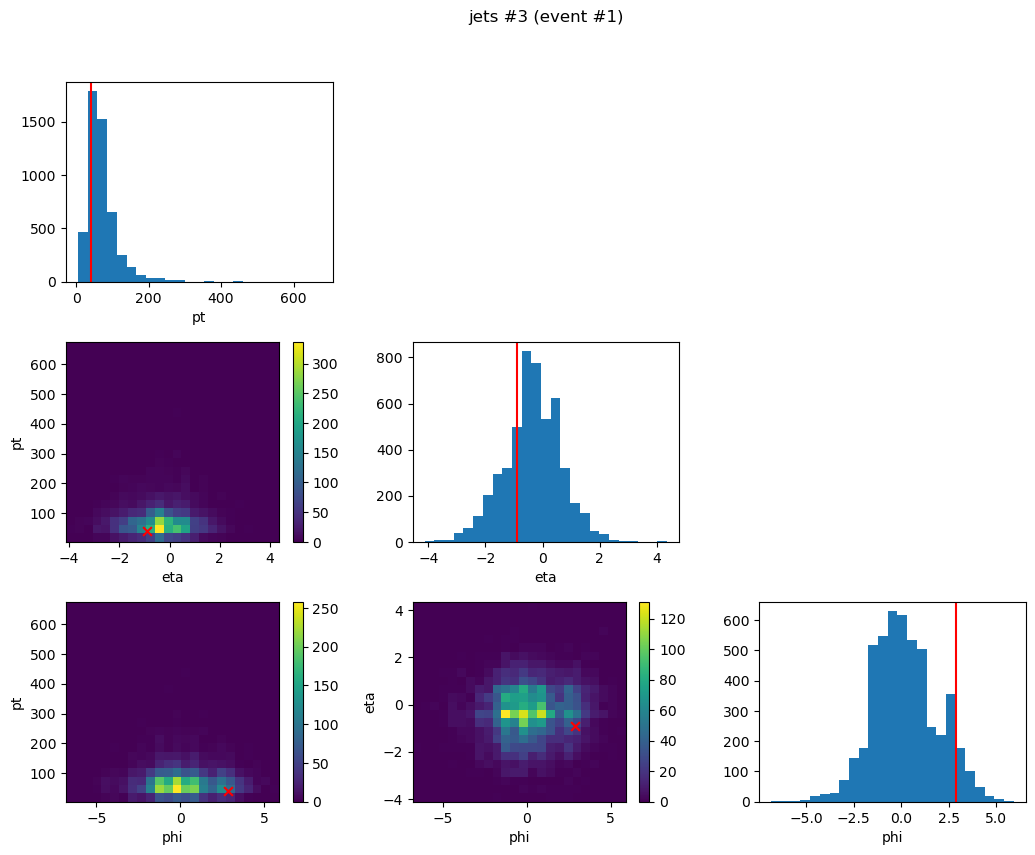

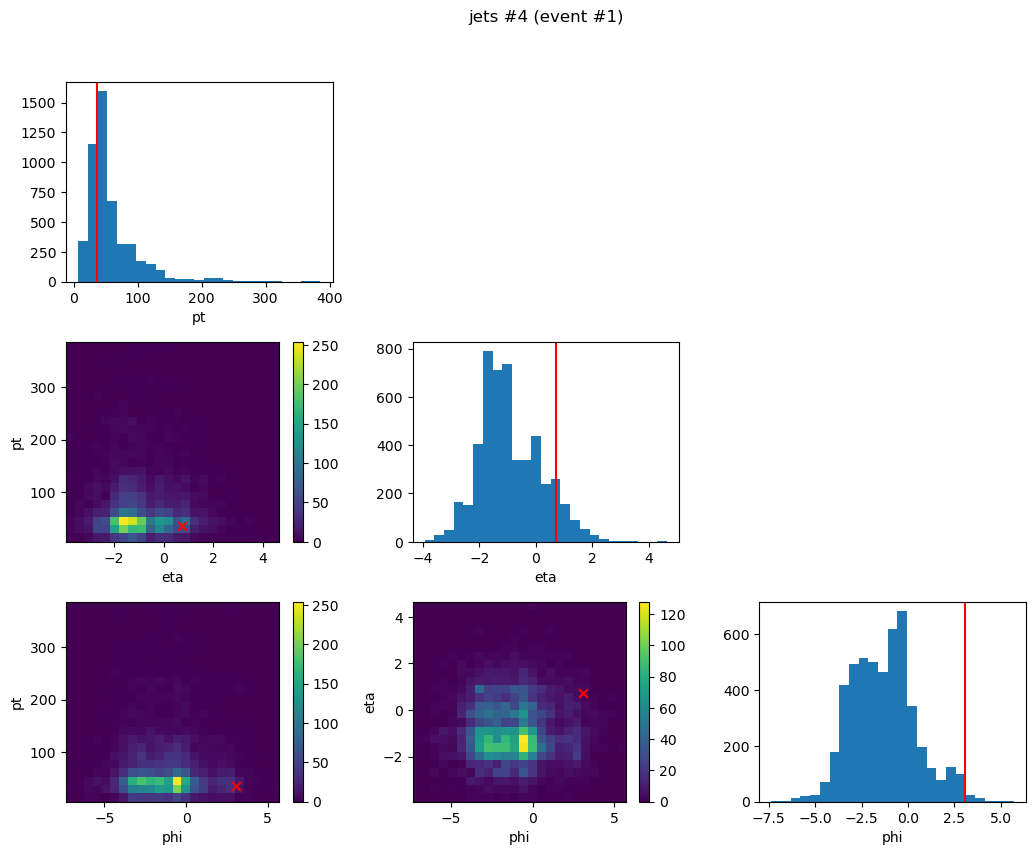

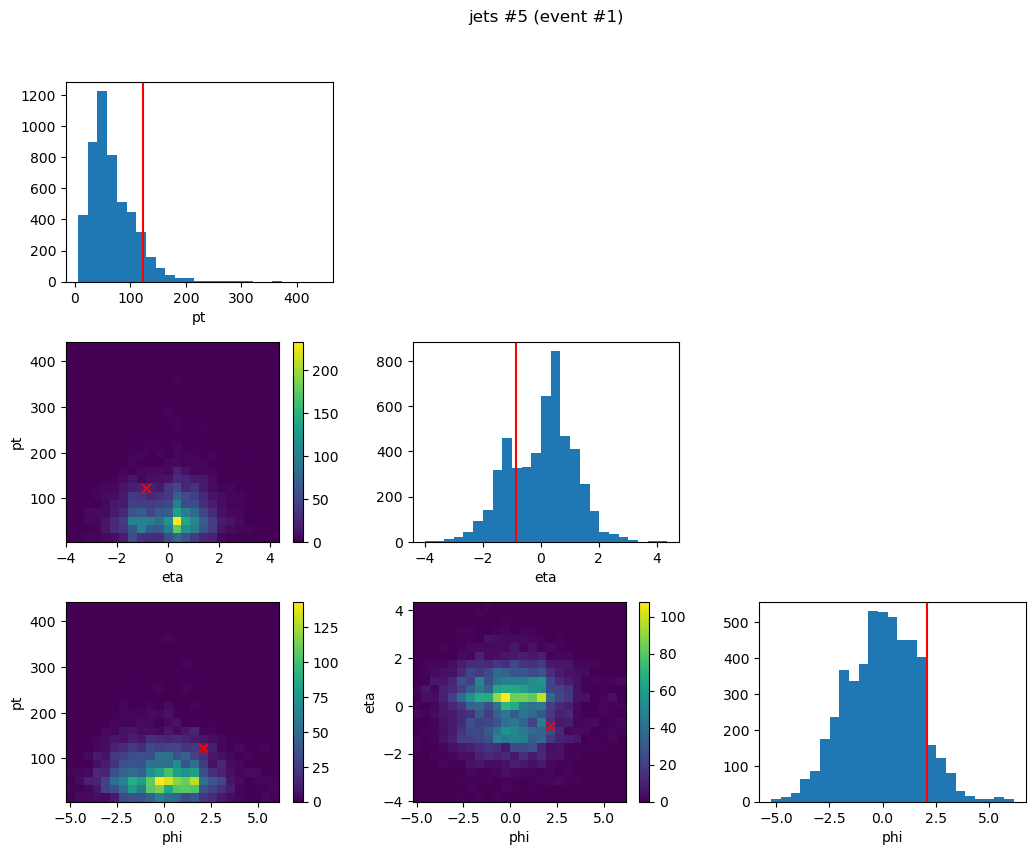

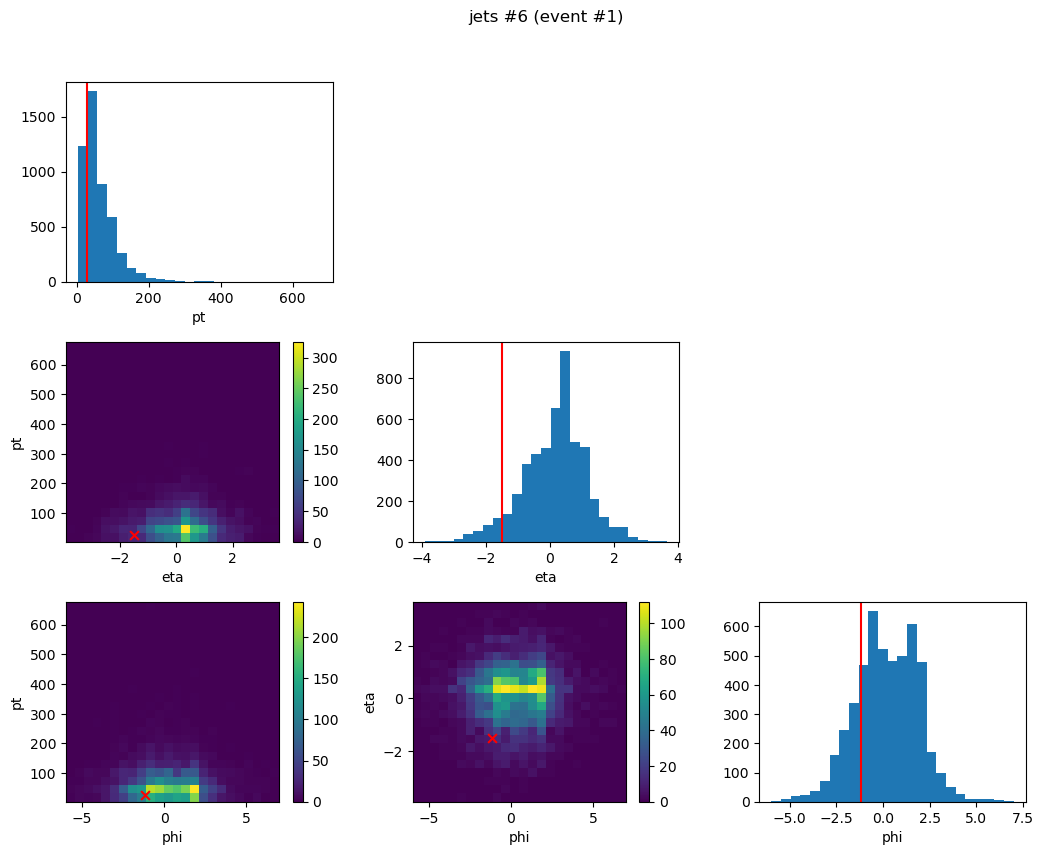

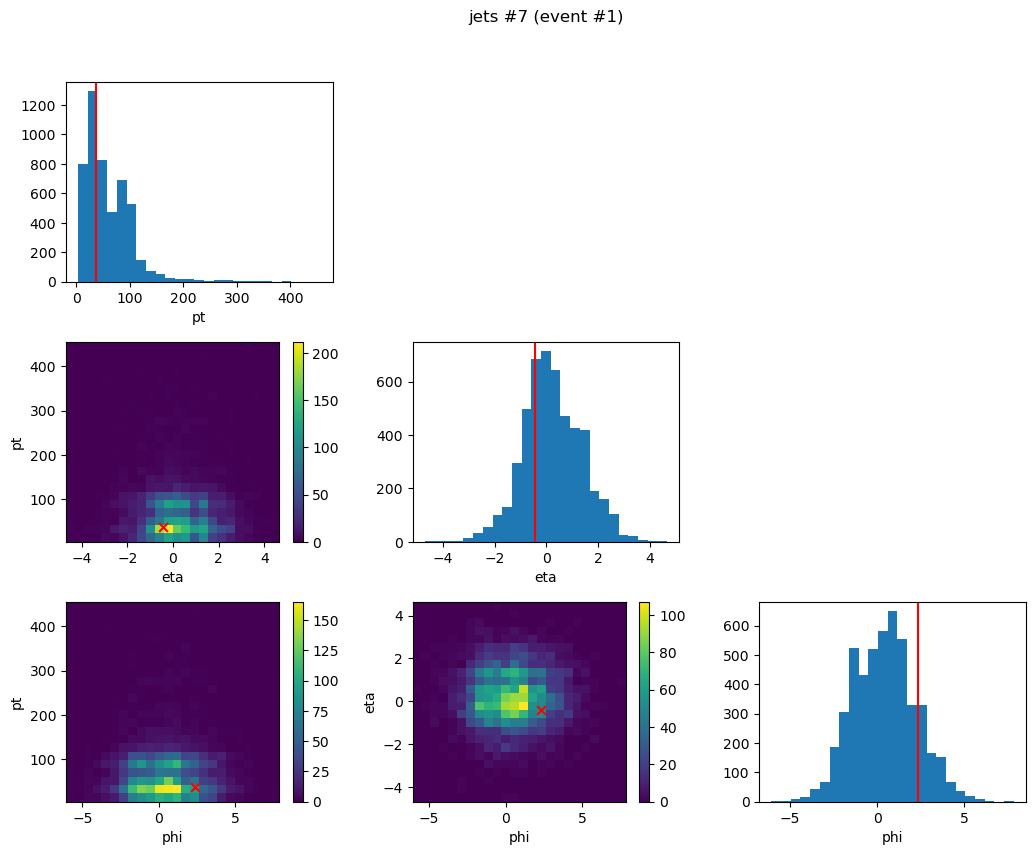

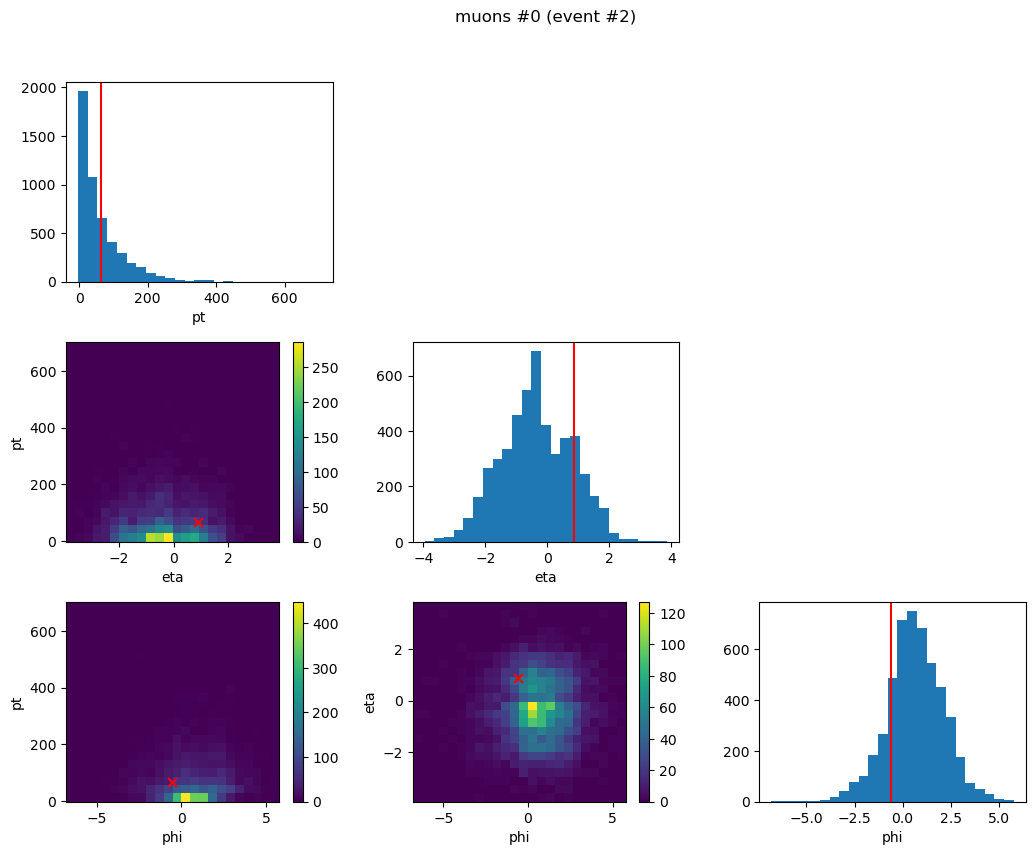

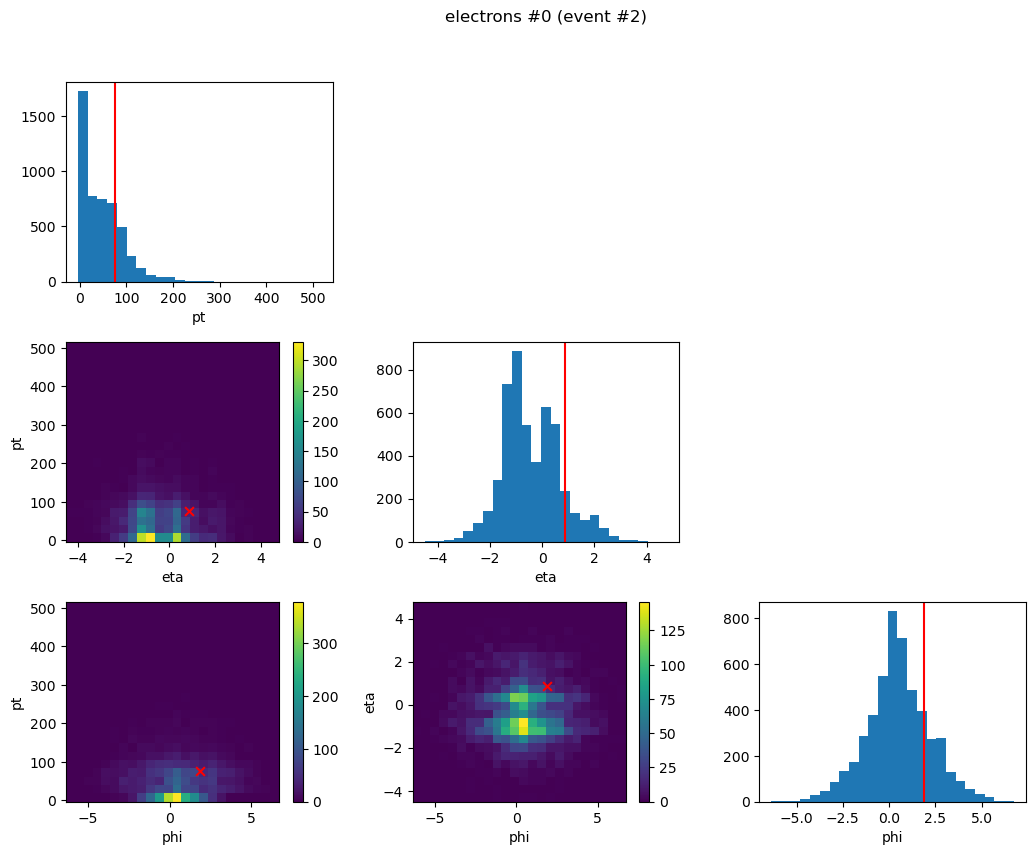

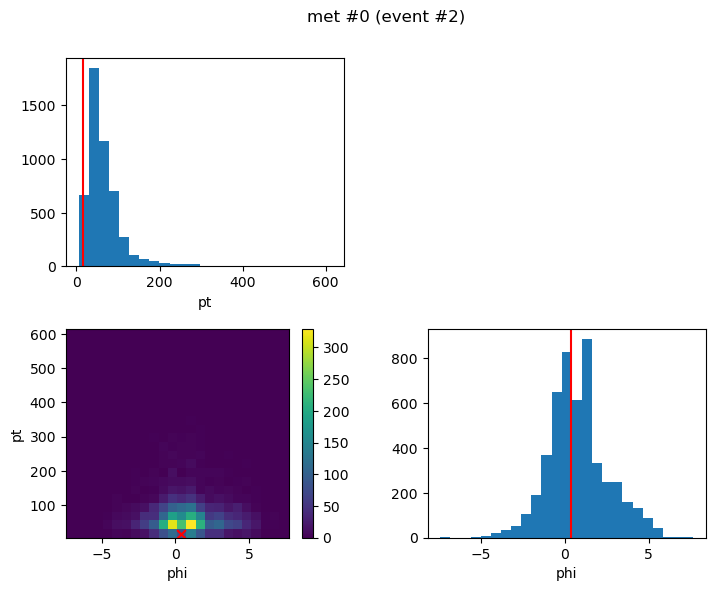

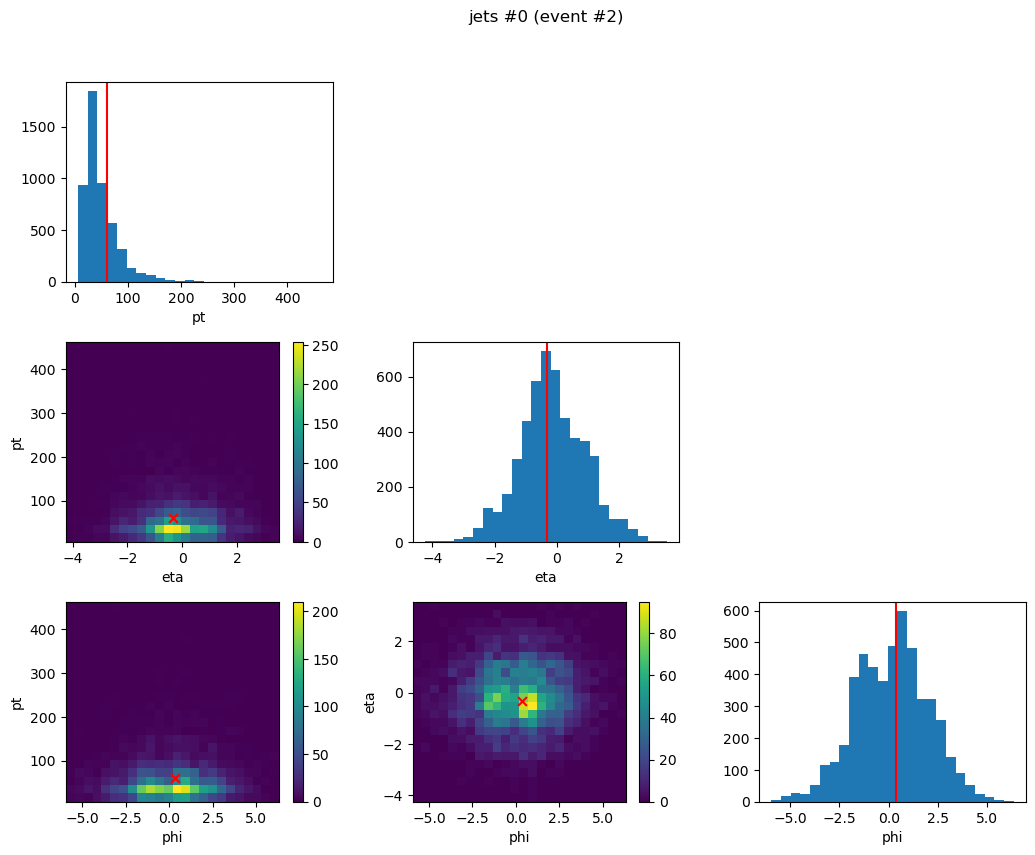

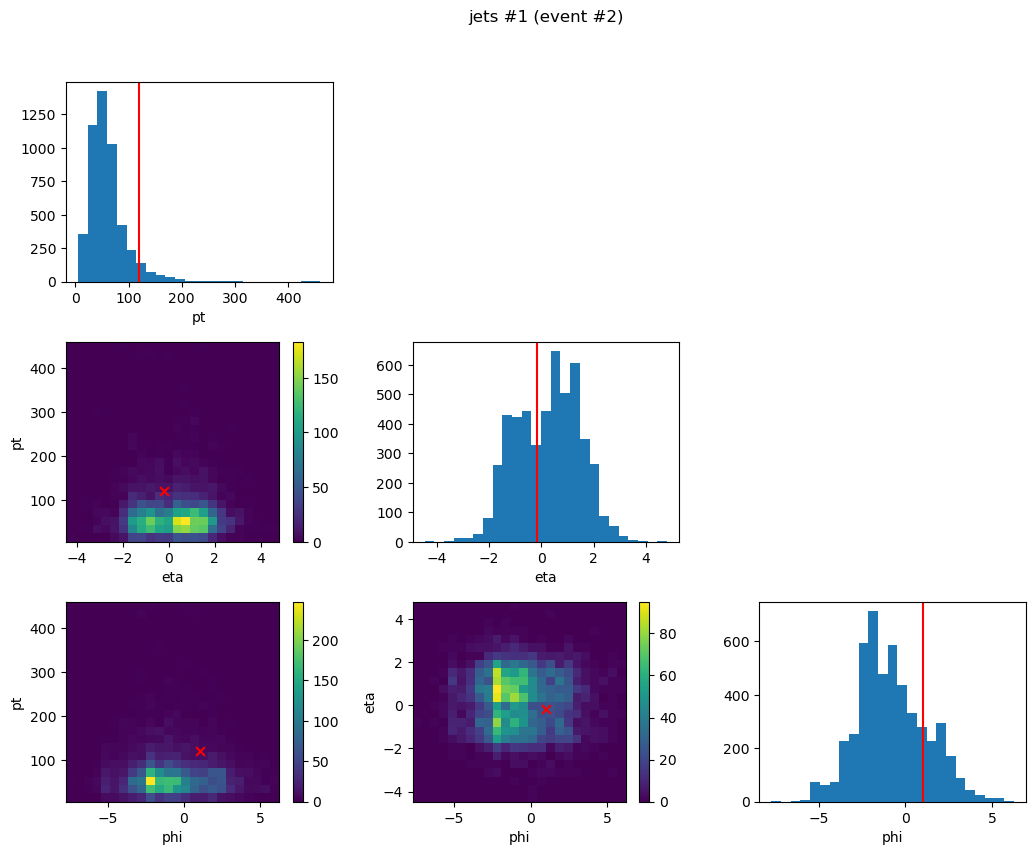

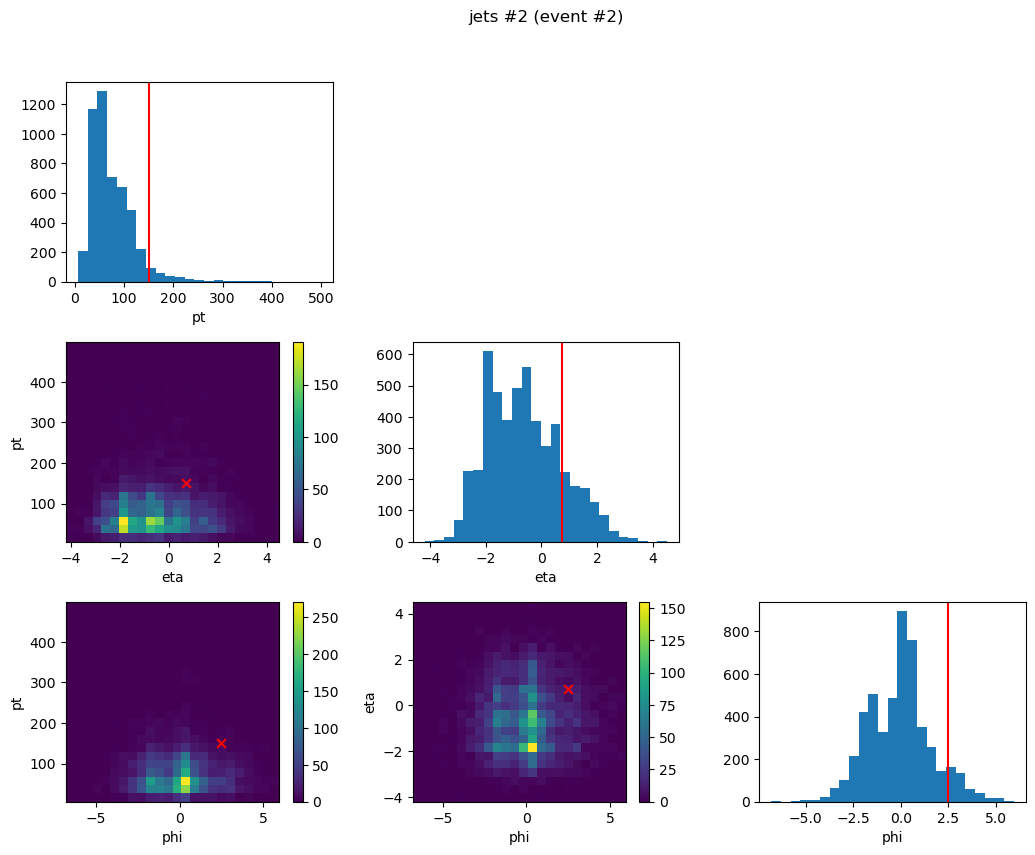

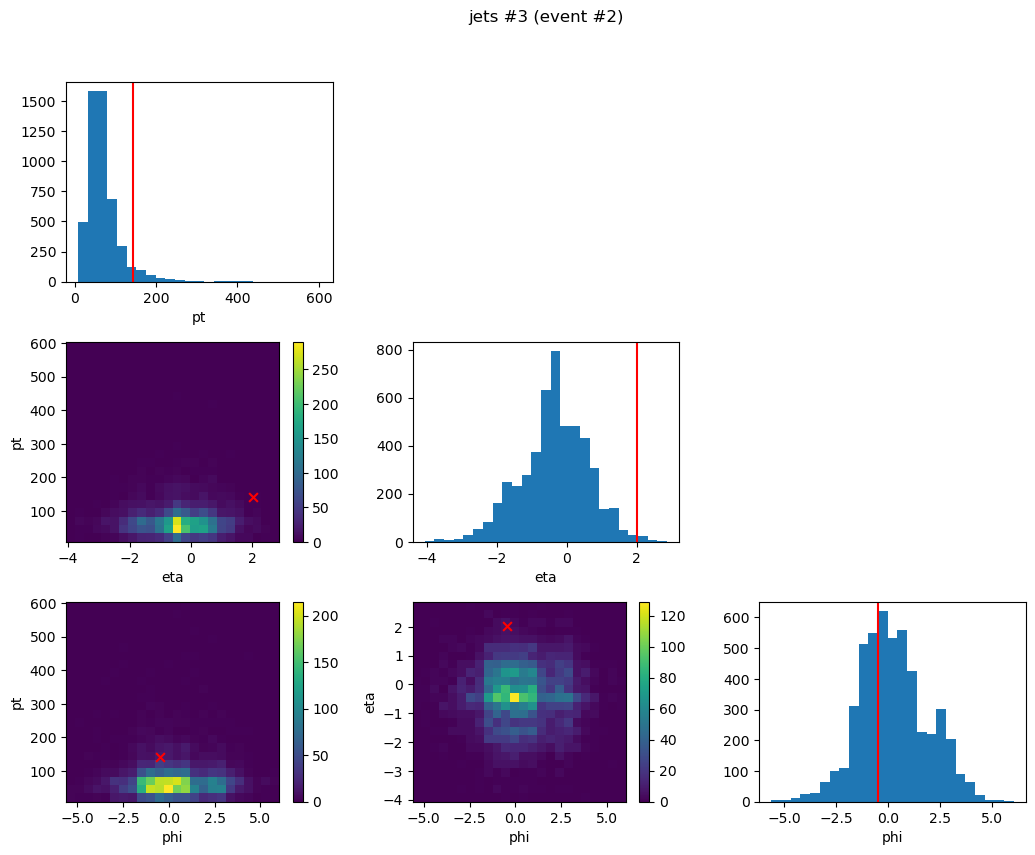

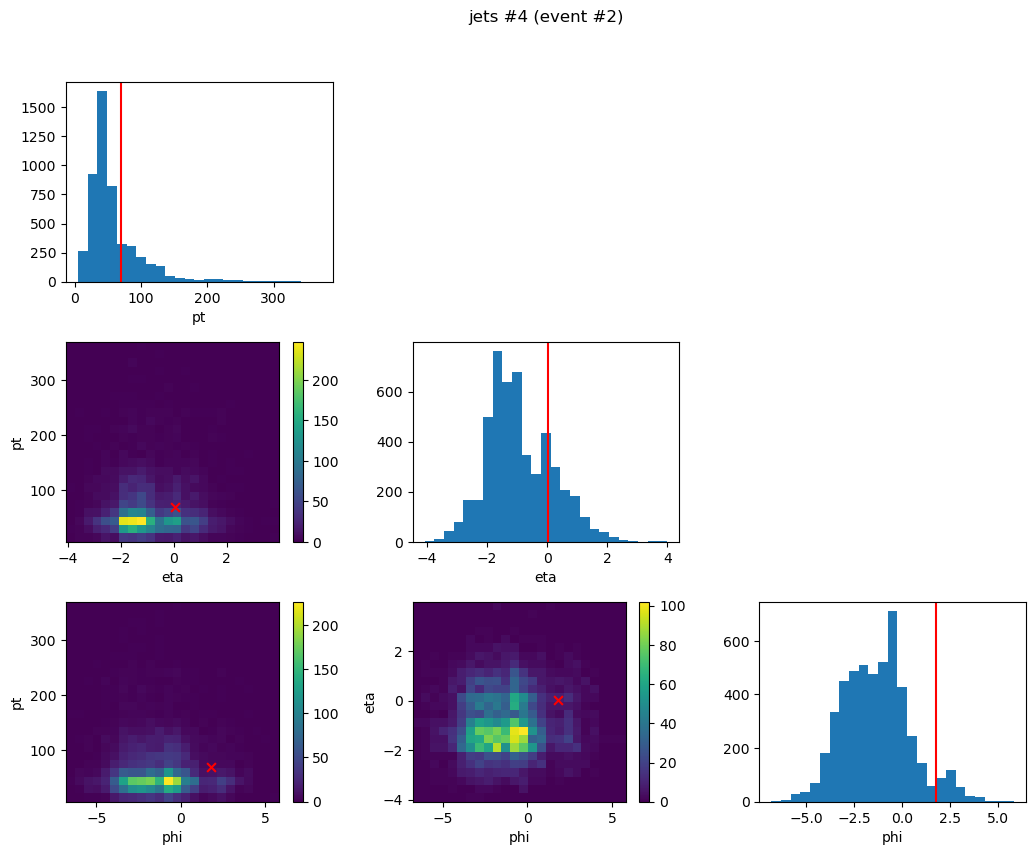

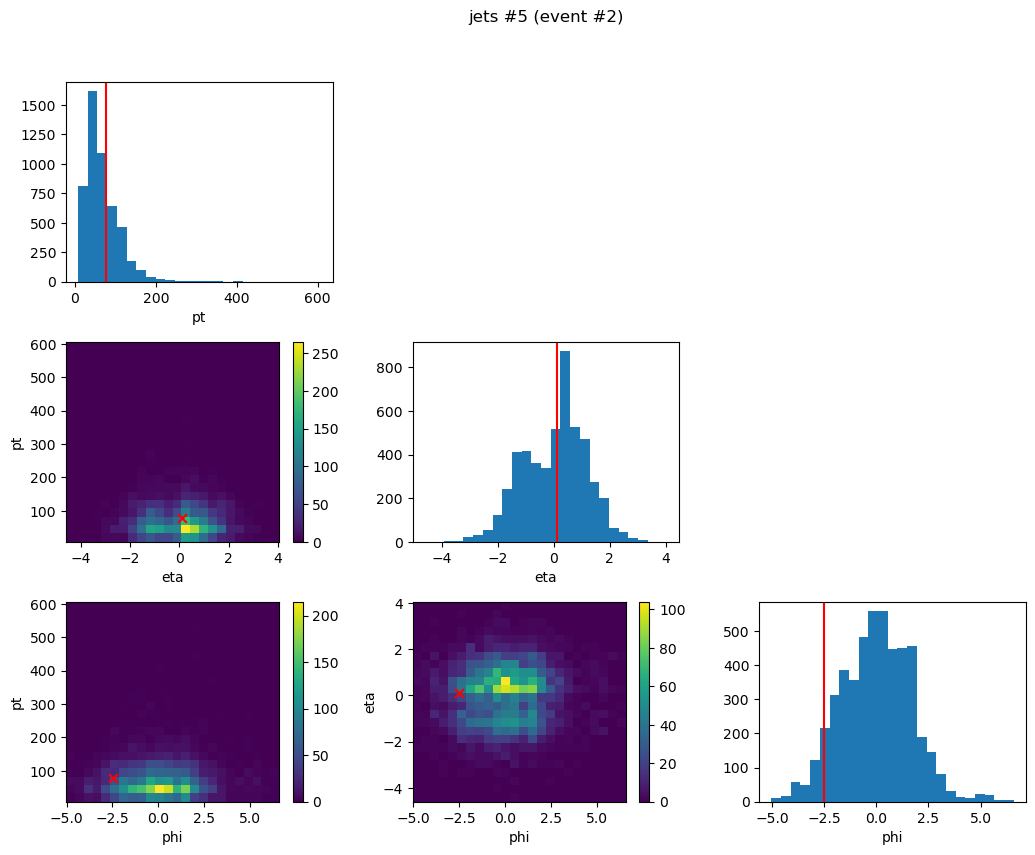

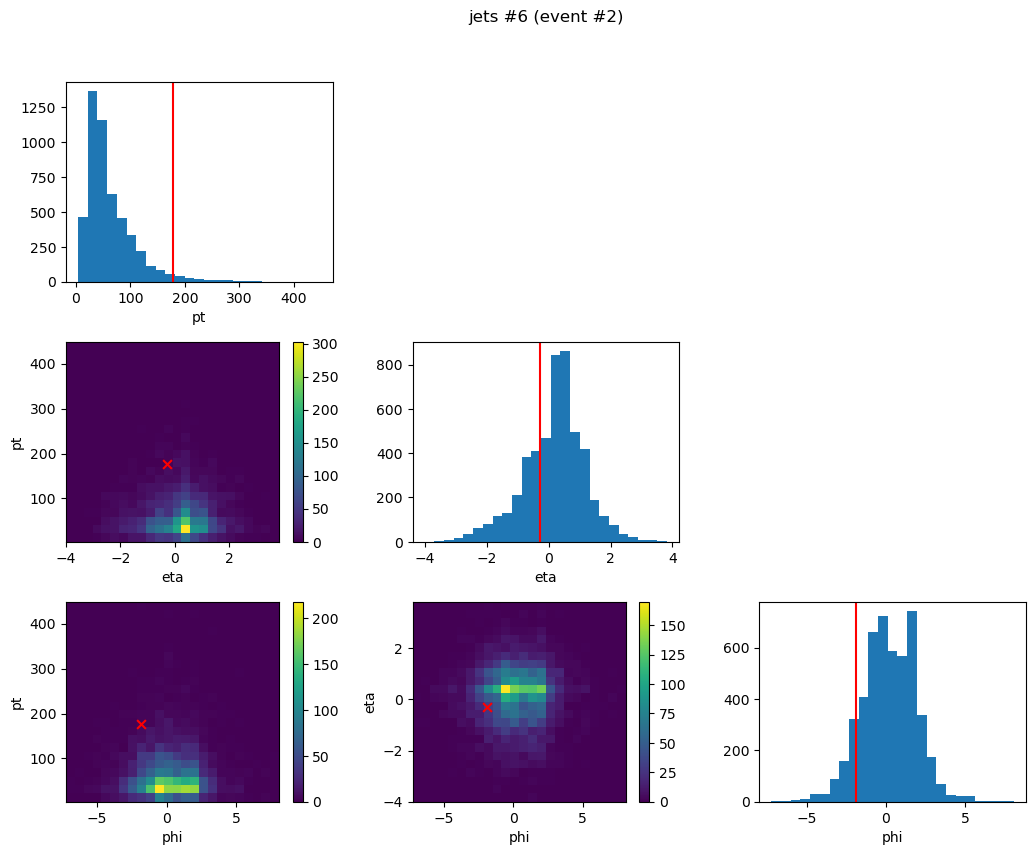

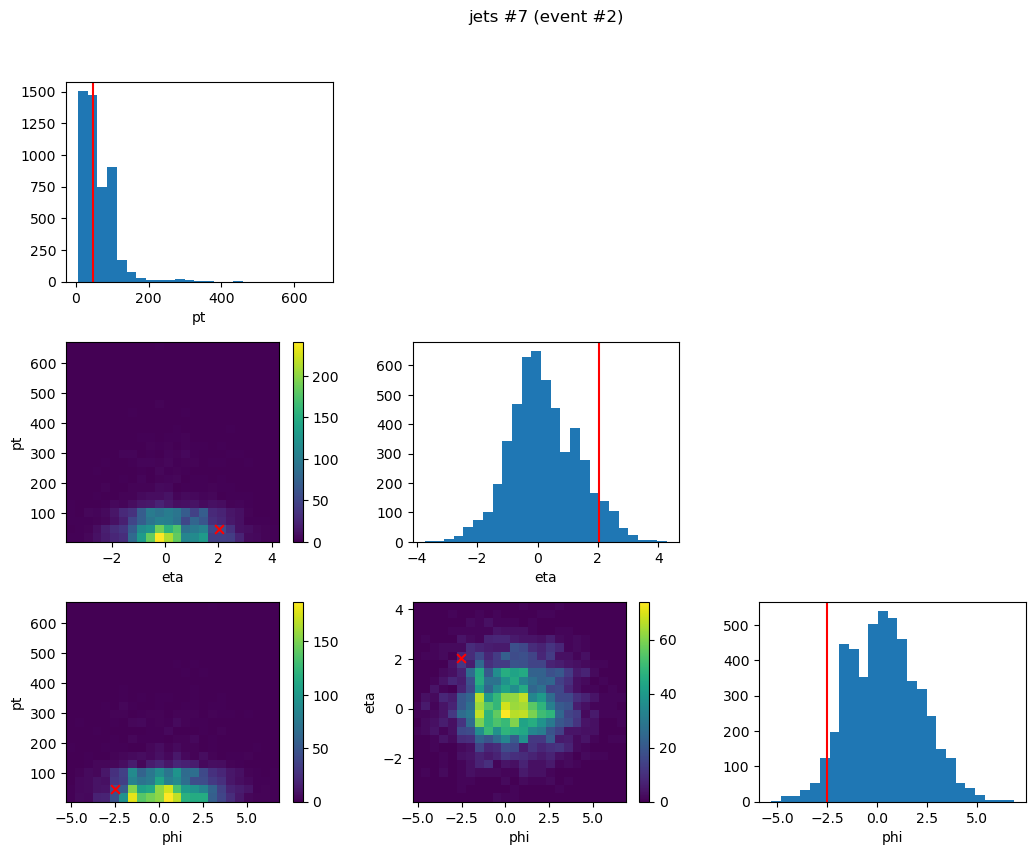

{'event_0_obj_electrons_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_electrons_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_0_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_2': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_3': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_4': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_5': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_6': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_7': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_1_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_2': <Figure siz

In [17]:
sampling = SamplingCallback(
    comb_dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 5000, 
    frequency = 1,
    raw = True,
    bins = 25,
    log_scale = False,
)

sampling.make_sampling_plots(model,show=True)

In [ ]:
##### Parameters #####
epochs = 1000
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-6)
model.set_optimizer(optimizer)

##### Scheduler #####
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer = optimizer, 
#     max_lr = 1e-3, 
#     epochs = epochs, 
#     steps_per_epoch = steps_per_epoch_train, 
#     pct_start = 0.20, 
#     anneal_strategy='cos', 
#     cycle_momentum=True, 
#     base_momentum=0.85, 
#     max_momentum=0.95, 
#     div_factor=1e3, 
#     final_div_factor=1e5,
# )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=20, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'TT',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)



Training   : Batch size = 256 => 144 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/c821dd585316494fb4ca9da29c707cc1

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                                                                            …

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
sampling.make_sampling_plots(model,show=True)